In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# A. 정상성(Stationarity)

### 정상성
- 시계열 {$r_t$}는
    - "엄격한 정상성(Strictly Stationarity)"는 $(r_{t_1},...,r_{t_k})$의 확률 밀도 함수가 시간 이동에 대해 불변(invariant)해야 함을 의미한다. 즉, $(r_{t_1},...,r_{t_k})$와 $(r_{t_1+\tau},...,r_{t_k+\tau})$의 결합 분포(joint distribution)가 모든 시간 범위($\tau$)에 대해 동일해야 한다.(어려운 조건)
    - "약한 정상성(Weakly Stationarity)"는 $E(r_t)=\mu$이고 $Cov(r_t,r_{t-l})=\gamma_l$이다. 즉, $r_t$의 평균과 $r_t$와 $r_{t-l}$ 사이의 공분산이 모든 정수 $l$에 대해 시간 불변(time invariant)해야 한다.
        - 엄격한 정상성 + 평균 & 분산이 유한 => 약한 정상성 (역은 성립하지 않음)
        - 시계열이 정규 분포를 따른다면, 약한 정상성은 엄격한 정상성과 동등하다고 할 수 있다.
    - "화이트 노이즈(White noise)"는 평균이 0이고 분산이 $\sigma^2$인 독립항등분포를 따르는 수열 $\{r_t\}$을 가리킨다. 이를 $r_t\sim WN(0,\sigma^2)$로 표기한다.
    - "화이트 가우시안 노이즈(White Gaussian noise)"는 정규 분포를 따르는 화이트 노이즈 $\{r_t\}$이다. 이를 $r_t\sim WGN(0,\sigma^2)$로 표기한다.
    - "선형(Linear)"는 다음과 같이 나타낸다.$$r_t=\mu+\sum_{i=0}^{\infty}\psi_i a_{t-i}$$ 이때 $\mu$는 $r_t$의 평균, $\psi_0=1$, $\{a_t\}$는 화이트 노이즈이며 시점 t의 "shock"이라고 부른다.
        - $r_t$가 약한 정상성이려면 $i \rightarrow\infty$에 따라 $\psi_i^2\rightarrow0$이어야 한다.
        - $\gamma_l=Cov(r_t,r_{t-l})=\sigma_a^2\sum_{j=0}^{\infty}\psi_j\psi_{j+l}$

### 자기상관 함수(Autocorrelation function; ACF)
- 자기상관 함수(ACF)
    - $\gamma_l=Cov(r_t, r_{t-l})$: $r_t$의 시차-$l$(lag-$l$) 자기공분산
    - $\rho_{l} = \frac{Cov(r_{t},r_{t - l})}{\sqrt{Var(r_{t})Var(r_{t - l})}} = \frac{\gamma_{l}}{\gamma_{0}}$: $r_t$의 시차-$l$(lag-$l$) 자기상관
        - $\gamma_0 = Var(r_t)$, 모든 $l$에 대해 $\quad \gamma_l = \gamma_{-l}$, $|\gamma_l| \leq \gamma_0$; $\rho_0=1$, 모든 l에 대해 $\rho_l=\rho_{-l}$, $-1\leq\rho_l\leq1$
        - 약한 정상성 가정 하에서, $\gamma_l$과 $\rho_l$은 $t$에 독립적이다.
- 표본 자기상관 함수(Sample Autocorrelation function; SACF)
    - 주어진 표본 $\{r_t\}_{t=1,...,T}$의 시차-$l$ 표본 자기상관 함수는 다음과 같이 정의된다.$$\hat{\rho}_l = \frac{\sum_{t=l+1}^{T} ((r_t - \bar{r}) \cdot (r_{t-l} - \bar{r}))}{\sum_{t=1}^{T} (r_t - \bar{r})^2},\quad\bar{r} = \frac{1}{T} \sum_{t=1}^{T} r_t$$
    - 만약 $\{r_t\}$가 $r_t=\mu+\sum_{i=0}^{q}\psi_i a_{t-i}$를 만족하는 약한 정상적 시계열이며, $\psi_0=1$이고 $\{a_j\}$: 평균이 0인 독립항등분포라면, $\hat{\rho_l}$는 $l> q$일 때, 평균이 0이고 분산이 $(1+2\sum_{i=1}^{l-1}\hat{\rho_i}^2)/T$인 정규분포에 수렴한다.
    - 화이트 노이즈의 경우, 모든 ACF가 0이다. 실제로, 만약 모든 SACF가 거의 0에 가깝다면, 그 시계열은 화이트 노이즈다.

### ACF 검정
- 독립 ACF 검정. $H_0: \rho_l=0$ vs $H_1: \rho_l\neq0$
    - t-값: $\frac{\hat{\rho_l}}{\sqrt{(1+2\sum_{i=1}^{l-1}\hat{\rho_i}^2)/T}}$
    - 만약 $Z_{\alpha/2}$가 $N(0,1)$의 $100(1-\alpha/2)%$ 백분위수라면, t-값이 $Z_{\alpha/2}$보다 크다면 $H_0$를 기각한다.
    - 단순화를 위해 많은 소프트웨어 패키지는 $1/T$를 0이 아닌 모든 $l$에 대해 $\hat{\rho_l}$의 점근적 분산으로 사용한다.
- Portmanteau 검정. $H_0: \rho_1=...=\rho_m=0$ vs $H_i: \rho_i\neq0$, $i\in\{1,...,m\}$
    - Box and Pierce(1970): $Q(m)=T\sum_{l=1}^{m}\hat{\rho_l}^2\approx\chi^2(m)$ (점근적)
    - Ljung and Box(1978): $Q^*(m)=T(T+2)\sum_{l=1}^{m}\frac{\hat{\rho_l}^2}{T-l}\approx\chi^2(m)$ (점근적)
    - 만약 $Q(m)$이 $\chi_{\alpha}^2$보다 크다면, $H_0$를 기각한다. 여기서 $\chi_{\alpha}^2$는 $\chi^2(m)$ 분포의 $100(1-\alpha)%$ 백분위수이다. 또는 p-값이 $\alpha$보다 작거나 같으면 $H_0$를 기각한다.
    - $m\approx \ln(T)$이 더 나은 검정력을 제공한다.

### 정상적 v.s. 비정상적
- 정상 시계열은:
    - 대략 수평적이다. $\rightarrow$ 추세 없음
    - 분산이 변하지 않는다.
    - 장기적으로 예측할 수 있는 규칙이 없다. $\rightarrow$ 계절성 없음
    - 변환은 분산을 안정화하는 데 도움을 준다.
    - ARIMA 모델링을 위해서는 평균을 안정화하는 것도 필요하다.
    - 화이트 노이즈는 정상성을 나타내지만, 역은 성립하지 않는다.
- 비정상(non-stationary) 시계열의 구분
    - 시간에 따른 그래프
    - 정상적 데이터의 ACF는 빠르게 0으로 감소한다.
    - 비정상적 데이터의 ACF는 느리게 감소한다.
    - 비정상적 데이터의 $\gamma_1$는 대체로 큰 양수를 갖는다.

### Wold's Representation Theorem
- Wold's Representation Theorem(Wold의 표현 정리)
    - $\{r_t\}$가 평균이 0인 약한 정상 시계열이라고 가정한다. 다음과 같이 나타낼 수 있다. $$r_t=\Psi(L)\epsilon_t=\sum_{i=0}^{\infty}\psi_i\epsilon_{t-i}\quad(General Linear Process; 일반 선형 과정)$$ 이때, $\psi_0=1$, $\sum_{i=0}^{\infty}\psi_i^2<\infty$이고 $\epsilon_t\sim WN(0,\sigma^2)$를 innovation이라고 부른다.
    - Wold 표현은 급수를 innovation들의 선형 함수로 나타낸다.
    - $\mathbb{E}[r_t]=0$, $\mathrm{var}[r_t]=\sigma^2\sum_{i=0}^{\infty}\psi_i^2$
    - $\mathbb{E}[r_t|\Omega_{t-1}]=\sum_{i=1}^{\infty}\psi_i\epsilon_{t-i}$, $\mathrm{var}[r_t|\Omega_{t-1}]=\sigma^2$ 이때 정보 집합 $\Omega_{t-1}$는 $\epsilon_{t-1},\epsilon_{t-2},...$이다.
    - 조건부 평균이 시간이 지남에 따라 변하는 정보 집합에 대응하여 움직인다는 점이 중요하다.
- 합리적으로 분포된 지연(Rational Distributed Lags): Wold 표현을 근사
    - $B(L)\approx\frac{\Phi(L)}{\Theta(L)}$ 이때, $\Phi(L)=1-\phi_1L-...-\phi_pL^p$이고 $\Theta(L)=1-\theta_1L-...-\theta_qL^q$

### Ergodicity: 독립항등분포, 마르코프 체인

# B. 랜덤 워크와 차분

### 랜덤 워크(Random walk)
- 랜덤 워크: $p_t=p_{t-1}+\epsilon_t$ 이때 $\epsilon_t\sim WN(0,\sigma^2)$
    - 비정상 데이터에 널리 사용된다.(예. 구글 주가의 일일 변화)
    - 예측 원점에서의 $l$-스텝 예측 $h:$ $\hat{p}_{h+l|h}=\mathbb{E}[p_{h+l}|p_h]=p_h$
        - 마지막 관측값이 예측값이다.(나이브)
        - 미래의 상승과 하락 움직임의 가능성은 동일하다.
        - 예측할 수 없으며 형균 회귀하지 않는다.
    - $l$-스텝 예측 오차: $\hat{\epsilon}_{h+l|h}=\mathbb{E}[\epsilon_{h+l}|\epsilon{h}]=\epsilon_{h+l}+...+\epsilon_{h+1}$, $\mathrm{Var}(\hat{\epsilon}_{h+l|h})=l\sigma^2\rightarrow\infty$ as $l\rightarrow\infty$
        - $\hat{p}_{h+l|h}$의 예측 구간의 길이는 $l\rightarrow\infty$에 따라 무한으로 발산한다: $l$이 증가함에 따라 $\hat{p}_{h+l|h}$의 점 예측의 유용성은 떨어진다.
        - $p_t$의 무조건 분산은 무한이다: 이론적으로 충분히 큰 $t$에 대해 $p_t$는 어떤 실수값도 가질 수 있다.
    - 과거의 shock이 현재 수익에 미치는 영향은 시간이 지나도 감소하지 않는다.
- 계절성 차분을 포함한 랜덤 워크: $p_t=p_{t-m}+\epsilon_t$ 이때 $\epsilon_t\sim WN(0,\sigma^2)$

### 드리프트(drift)가 있는 랜덤 워크
- 드리프트가 있는 랜덤 워크: $p_t=\mu+p_{t-1}+\epsilon_t$ 이때 $\epsilon_t\sim WN(0,\sigma^2)$
    - 예. 주가의 로그 시계열
    - 로그 가격은 시간 추세와 순수 랜덤 워크로 구성된다. $$p_t=t\mu+p_0+\epsilon_t+\epsilon_{t-1}+...+\epsilon_1$$
- 추세-정상 시계열: $p_t=\beta_0+\beta_1t+r_t$ 이때 $\{r_t\}$는 정상 시계열
    - 평균은 시간에 의존하지만 분산은 유한하고 시간 불변이다.
        - 드리프트가 있는 랜덤 워크 모델은 평균이 $t\mu+p_0$이고 분산이 $t\sigma^2$, 둘 다 시간 종속이다.
    - 추세-정상 시계열은 간단한 선형 회귀 분석을 통해 시간 추세를 제거하여 정상 시계열로 변환할 수 있다.

### Lag 연산자
- Lag(Backshift) 연산자 $L$: $Lr_t=r_{t-1}$
    - $L^2r_t=L(Lr_t)=Lr_{t-1}=t_{t-2},...,L^pr_t=r_{t-p}$
    - $\Phi(L)=\phi_1L+\phi_2L^2+...+\phi_pL^p=\sum_{i}^{p}\phi_iL^i$ 그리고 $\Phi(L)r_t=\phi_1r_{t-1}+...+\phi_pr_{t-p}=\sum_{i}^{p}\phi_ir_{t-i}$
- 차분(Differencing)
    - Lag 연산자는 차분의 과정을 표현할 때 유용하다.
    - 일차 차분: $\Delta r_t=(1-L)r=r_t-r_{t-1}$
    - 이차 차분: $\Delta r_t-\Delta r_{t-1}=(1-L)^2r_t=r_t-2r_{t-1}+r_{t-2}$
    - d차 차분: $(1-L)^dr_t$
    - 1차 차분에 따른 계절성 차분: $$(1-L)(1-L^m)r_t=(1-L-L^m+L^{m+1})r_t=r_t-r_{t-1}-r_{t-m}+r_{t-m-1}$$
        - 월별 데이터에 대해 $m=12$이고 전과 같은 결과를 얻을 수 있다.

### 차분(Differencing)
- 차분
    - 차분은 평균을 안정화하는 데 도움이 된다.
    - 차분한 시계열은 기존 시계열의 관측값 사이의 변화다: $\Delta r_t=r_t-r_{t-1}$
    - 첫 관측값에 대한 변화 $\Delta r_1$를 계산할 수 없기 때문에 차분한 시계열은 $T-1$개의 값을 가진다.
- 2차 차분
    - 가끔씩 차분한 데이터가 정상적이지 않을 수 있어 두 번 차분해야할 수도 있다: $\Delta r_t-\Delta r_{t-1}=(1-L)^2r_t=r_t-2r_{t-1}+r_{t-2}$이고 $T-2$개의 값을 가진다.
    - 실제로는 2차 차분 이상을 진행할 필요가 없다.
- 계절성 차분
    - 계절성 차분은 관측값과 예년에 대응하는 관측값 사이의 변화량이다: $r_t-r_{t-m}$ 이때 $m=$계절의 수
      - 월별 데이터는 $m=12$, 분기별 데이터는 $m=4$.
    - 계절성 차분한 시계열은 관측값이 $T-m$개이다.

### 단위근(Unit-root) 검정
- 단위근 비정상 시계열
    - 이자율, 환율, 주가 시계열은 비정상성을 띤다.
    - 주가 시계열의 비정상성은 주로 가격에 고정된 수준(level)이 없기 때문이다.
- 단위근 검정: 차분의 필요한 차수를 결정하는 통계적 검정이다
    1. 확장된 Dickey-Fuller 검정: 귀무가설은 데이터가 비정상이고 비계절성이다. $H_0:$ 비정상
    2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) 검정: 귀무가설은 데이터가 정상이고 비계절성이다. $H_0:$ 정상
    3. 계절성 데이터는 다른 검정이 가능하다.

### 확장된 Dickey-Fuller 단위근 검정 (ADF)
- Dickey-Fuller 단위근 검정 (DF)
    - $p_{t} = \phi_{1} p_{t-1} + e_{t}$
    - $H_0: \phi_{1} = 1 \quad \text{vs} \quad H_1: \phi_{1} < 1$ (AR(1) 모델)
    - $\hat{\phi}_1 = \frac{\sum_{t=1}^{T} p_{t-1} p_{t}}{\sum_{t=1}^{T} p_{t}^2}$, $\hat{\sigma}_e^2 = \frac{\sum_{t=1}^{T} (p_{t} - \hat{\phi}_1 p_{t-1})^2}{T-1}$
    - $DF \equiv t\text{ ratio} = \frac{\hat{\phi}_1 - 1}{\text{std}(\hat{\phi}_1)} = \frac{\sum_{t=1}^{T} p_{t-1} e_{t}}{\hat{\sigma}_e\sqrt{\sum_{t=1}^{T} p_{t}^2}}$
    - 대규모 표본이 필요하다.
- 확장된 Dickey-Fuller 단위근 검정 (ADF)
    - $\Delta x_t = c_t + \gamma x_{t-1} + \sum_{i=1}^{p-1} \phi_i \Delta x_{t-i} + e_t$
    - $c_t$는 0 또는 상수 또는 $c_t=\alpha+\beta t$이다.
    - $H_0: \gamma = 0 \quad \text{vs} \quad H_1: \gamma < 0$ (AR(p) 모델)
    - $ADF \equiv t\text{ ratio} = \frac{\hat{\gamma}}{\text{std}(\hat{\gamma})}$
- 기각하에서 0이 아닌 평균을 허용함
    - $p_t-\mu=\phi_1(p_{t-1}-\mu)+e_t$
    - $p_t=\alpha+\phi_1p_{t-1}+e_t$, $\alpha=\mu(1-\phi_1)$
    - $\alpha$는 $\phi_1=1$(null)일 때 사라진다.
    - $\alpha$는 기각됐을 때 존재하므로 회귀 시에 절편을 포함시킨다.
- 기각하에서 결정적 선형 추세를 허용함
    - $p_t-a-bt=\phi_1(p_{t-1}-a-bt)+e_t$
    - $p_t=\alpha+\beta t+\phi_1p_{t-1}+e_t$, $\alpha=a(1-\phi_1)+b\phi_1$, $\beta=b(1-\phi_1)$
    - 귀무 가설하에서 드리프트가 있는 랜덤 워크이므로 $p_t=b+p_{t-1}+e_t$이다.
    - 결정적 추세 대립 가설하에서 절편과 추세 모두 회귀 시에 포함된다.

### 예제: 단위근 KPSS 검정

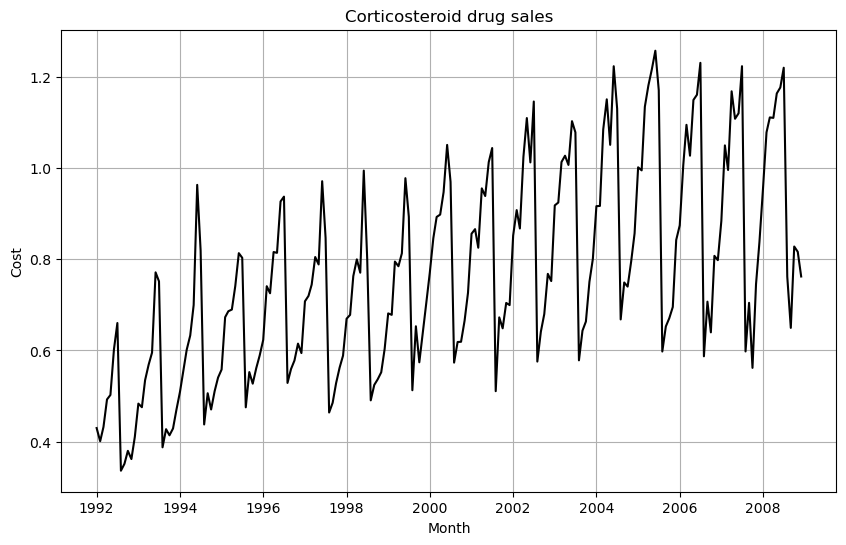

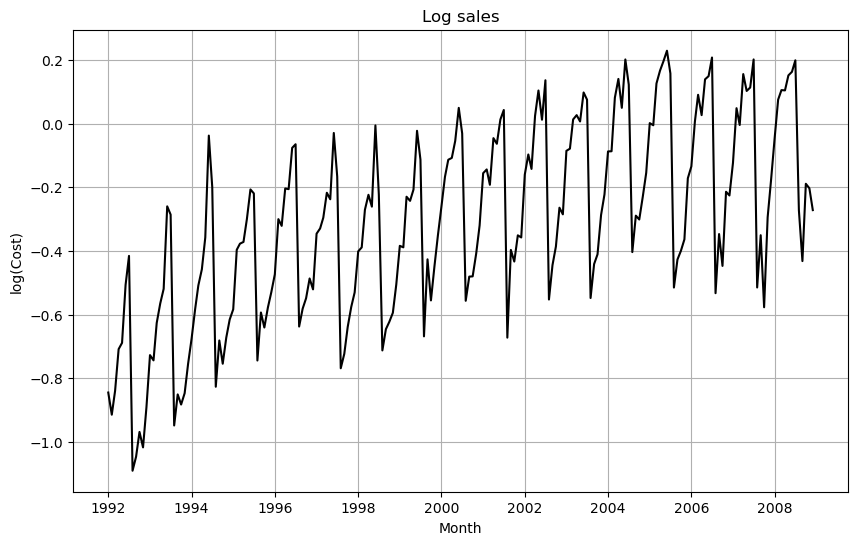

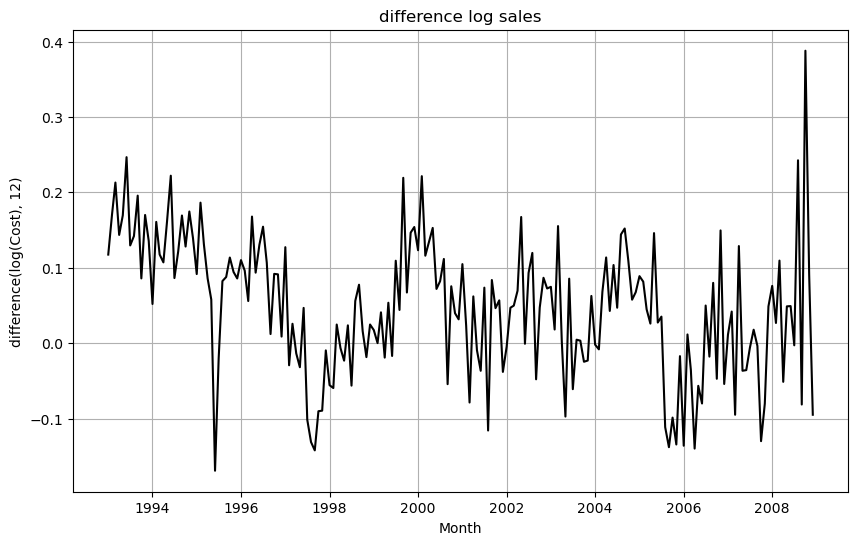

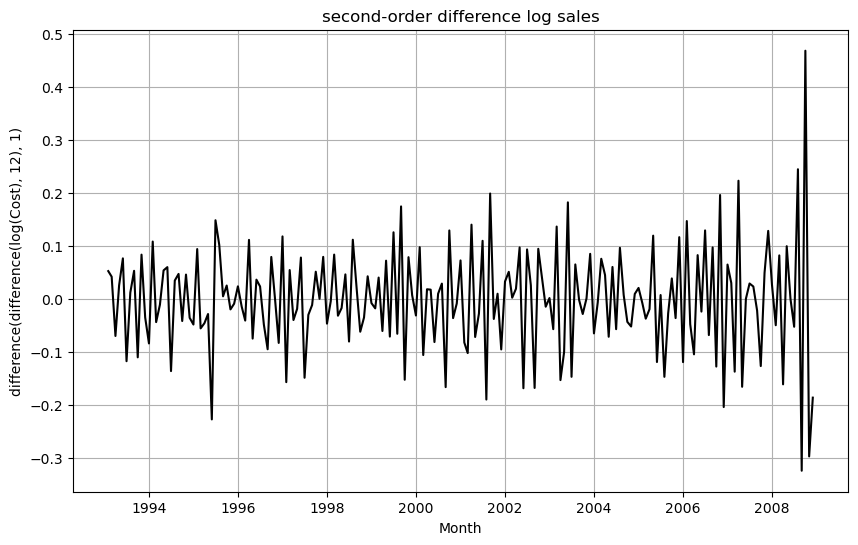

In [22]:
def log_series(series):
    tmp = np.log(series)
    return pd.Series(tmp, series.index)

def diff_series(series, periods=1):
    return series.diff(periods=periods)

def plot_series(series, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series,  color='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

h02 = pd.read_csv("h02.csv")
h02 = pd.Series(list(h02.x), pd.date_range(start='1/1/1992', periods=h02.shape[0], freq='1MS'))
plot_series(h02, "Month", "Cost", "Corticosteroid drug sales")
log_h02 = log_series(h02)
plot_series(log_h02, "Month", "log(Cost)", "Log sales")
diff12_h02 = diff_series(log_h02, 12)
plot_series(diff12_h02, "Month", "difference(log(Cost), 12)", "difference log sales")
diff1_diff12_h02 = diff_series(diff12_h02)
plot_series(diff1_diff12_h02, "Month", "difference(difference(log(Cost), 12), 1)", "second-order difference log sales")

### 차분 자동 선택
- STL 분해: $y_t=T_t+S_t+R_t$
- 계절성 강도 $F_s=\mathrm{max}[0,1-\frac{Var(R_t)}{Var(S_t+R_t)}]$
- $F_s>0.64$이면, 계절성 차분을 한 번 시행한다.

In [3]:
def seasonal_strength(series):
    stl_result = STL(series).fit()
    r = stl_result.resid
    s = stl_result.seasonal
    var1 = r.var()
    var2 = (s+r).var()
    return max(0, 1-var1/var2)

seasonal_strength(log_h02)

0.9708953840295775

# 3. 자기회귀(Autoregressive, AR) 모델

### 자기회귀 모델
- AR(1) 모델
    - $r_t = \phi r_{t-1} + \epsilon_t$ 이때 $\epsilon_t \sim \text{WN}(0, \sigma^2)$ $\rightarrow$ $(1 - \phi L) r_t = \epsilon_t$
        - $\phi=0$, $c=0$일 때, $r_t$는 WN과 동일하다.
        - $\phi=1$, $c=0$일 때, $r_t$는 RW과 동일하다.
        - $\phi=1$, $c\neq0$일 때, $r_t$는 드리프트가 있는 WN과 동일하다.
        - ARIMA() 함수는 상수항이 필요한지 여부를 처리하거나 필요한 경우 사용자가 재정의할 수 있다.
    - 정상적이려면 $\mathbb{E}[r_t]=\mu=c/(1-\phi)$, $\text{var}[r_t] = \sigma^2 \sum_{i=0}^{\infty} \phi^{2i} = {\sigma^2}/{(1 - \phi^2)}$
        - 정상 조건하에 $\mathbb{E}[r_t]=\mathbb{E}[r_{t-1}]=\mu$이다. 이때, $\mu=c+\phi\mu$이고, $r_t-\mu=\phi(r_{t-1}-\mu)+\epsilon_t$이다.
        - "MA 표현": $r_t-\mu=\phi(r_{t-1}-\mu)+\epsilon_t=...=\epsilon_t+\phi\epsilon_{t-1}+\phi^2\epsilon_{t-2}+...$
        - 정상성을 위해 $|\phi|<1$이 필요하다.
        - $\phi$가 경계에 가까울수록 과정이 무조건 평균(이 경우에 0)을 기준으로 위아래로 더 많이 움직인다.
        - $\phi<0$일 때, $r_t$는 양과 음의 값에서 진동하고자 한다.
    - $\mathbb{E}[r_t|r_{t-1}]=\phi r_{t-1}$, $\mathrm{var}[r_t|r_{t-1}]=\sigma^2$
    - $\mathrm{var}[r_t]=\gamma_0=\sigma^2/(1 - \phi^2)$, $\gamma_l=\phi^l\sigma^2/(1-\phi^2)$, $\rho_l=\phi^l$

### 예시
1. $r_t=-0.8r_{t-1}+\epsilon_t$, $\epsilon_t\sim WN(0,1)$
2. $r_t=18-0.8r_{t-1}+\epsilon_t$, $\epsilon_t\sim WN(0,1)$

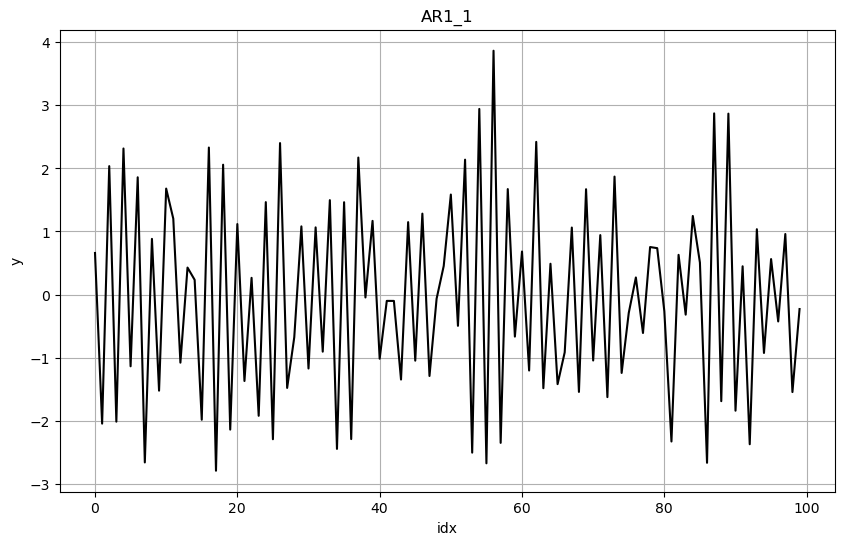

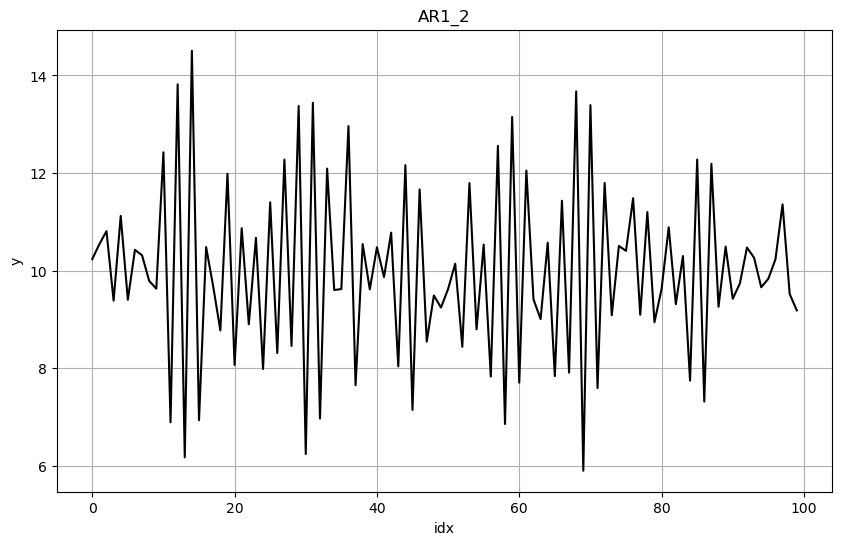

In [24]:
def AR1(c=0, phi=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c/(1 - phi) + noise[0]]
    for i in range(1, n):
        data.append(c + phi * data[i-1] + noise[i])
    return data

ex_AR1_1 = pd.Series(AR1(phi=-0.8))
plot_series(ex_AR1, "idx", "y", "AR1_1")

ex_AR1_2 = pd.Series(AR1(c=18, phi=-0.8))
plot_series(ex_AR2, "idx", "y", "AR1_2")

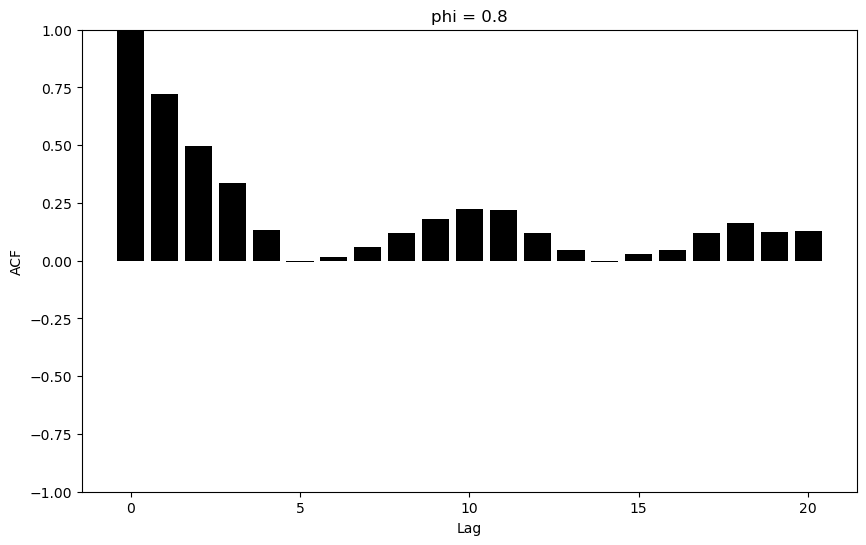

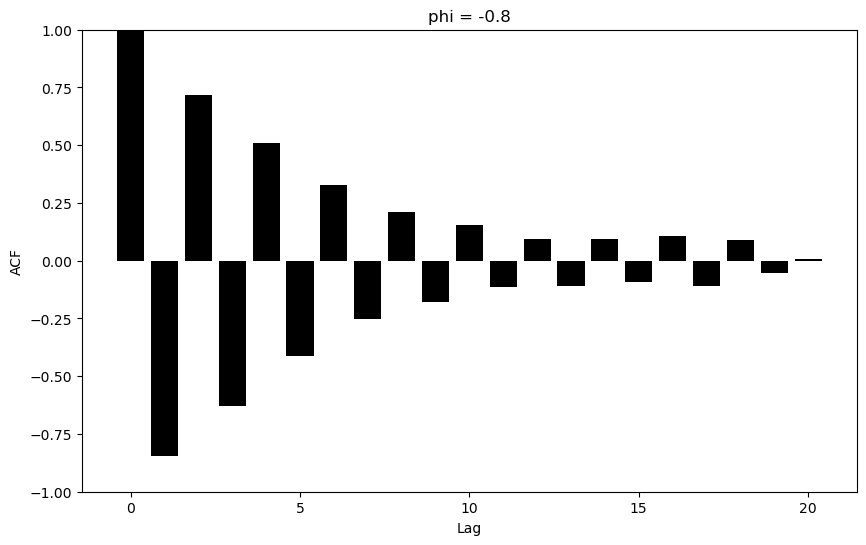

In [70]:
def show_ACF(series, title, start=0):
    plt.figure(figsize=(10, 6))
    ACF = acf(series, fft=False)
    plt.bar(range(start, ACF.shape[0]), ACF[start:], color='black')
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.ylim(-1, 1)
    plt.title(title)
    plt.show()

ex_AR1_3 = pd.Series(AR1(phi=0.8))
show_ACF(ex_AR1_3, "phi = 0.8")
show_ACF(ex_AR1_1, "phi = -0.8")

### p차 자기회귀 모델
- AR(p) 모델: p차 자기회귀 모델
$$r_t = \phi_0 + \phi_1 r_{t-1} + \cdots + \phi_p r_{t-p} + \epsilon_t,\quad\epsilon_t\sim WN(0,\sigma^2)$$
    - $\mathbb{E}(r_t) = \mu = \frac{\phi_0}{1 - \phi_1 - \cdots - \phi_p}$, $\rho_l = \phi_1 \rho_{l-1} + \cdots + \phi_p \rho_{l-p}$
        - $(1 - \phi_1 L - \phi_2 L^2 - \cdots - \phi_p L^p) \rho_l = 0$
        - 특성 방정식: $1 - \phi_1 x - \phi_2 x^2 - \cdots - \phi_p x^p = 0$
        - 특성근: 특성 방정식의 해의 역수
        - 모든 특성근이 절대값이 1보다 작을 때, ACF는 lag이 증가함에 따라 0으로 수렴한다.
    - 정상성의 일반적인 조건: 모든 특성근의 절대값이 1보다 작아야한다.
        - $p=1$일 때, $-1<\phi_1<1$
        - $p=2$일 때, $-1<\phi_2<2$, $\phi_2+\phi_1<1$, $\phi_2-\phi_1<1$

### 예시
1. $r_t=18-0.8r_{t-1}+\epsilon_t$, $\epsilon_t\sim WN(0,1)$
2. $r_t=8+1.3r_{t-1}-0.7r_{t-2}+\epsilon_t$, $\epsilon_t\sim WN(0,1)$

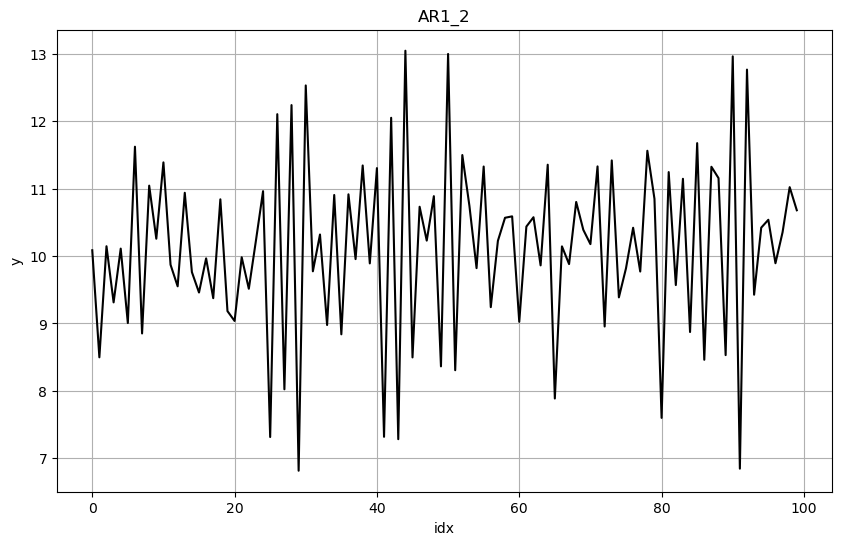

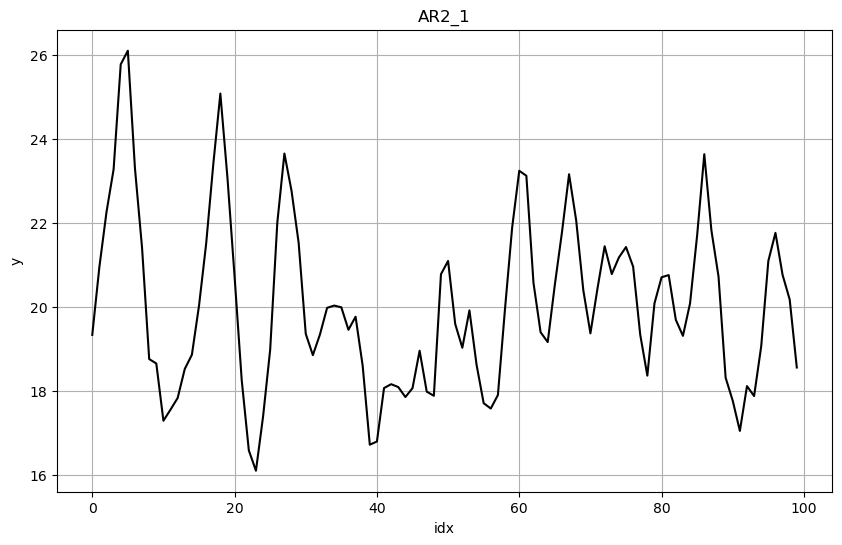

In [26]:
def AR2(c=0, phi1=0, phi2=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c/(1 - phi1 - phi2) + noise[0], c/(1 - phi1 - phi2) + noise[1]]
    for i in range(2, n):
        data.append(c + phi1 * data[i-1] + phi2 * data[i-2] + noise[i])
    return data

plot_series(ex_AR1_2, "idx", "y", "AR1_2")

ex_AR2_1 = pd.Series(AR2(c=8, phi1=1.3, phi2=-0.7))
plot_series(ex_AR2_1, "idx", "y", "AR2_1")

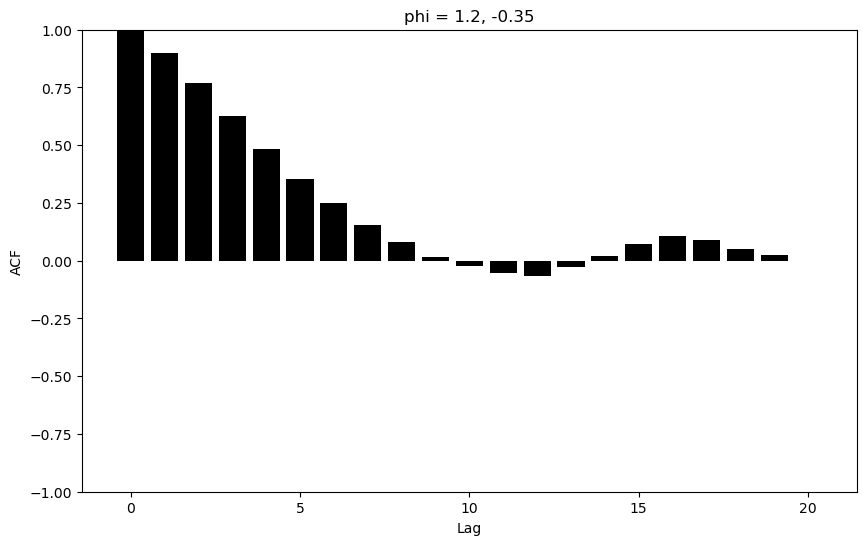

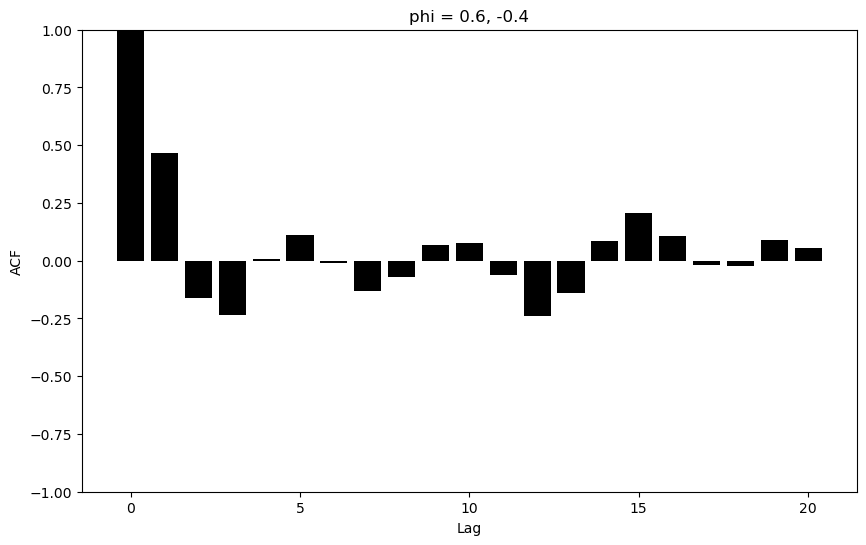

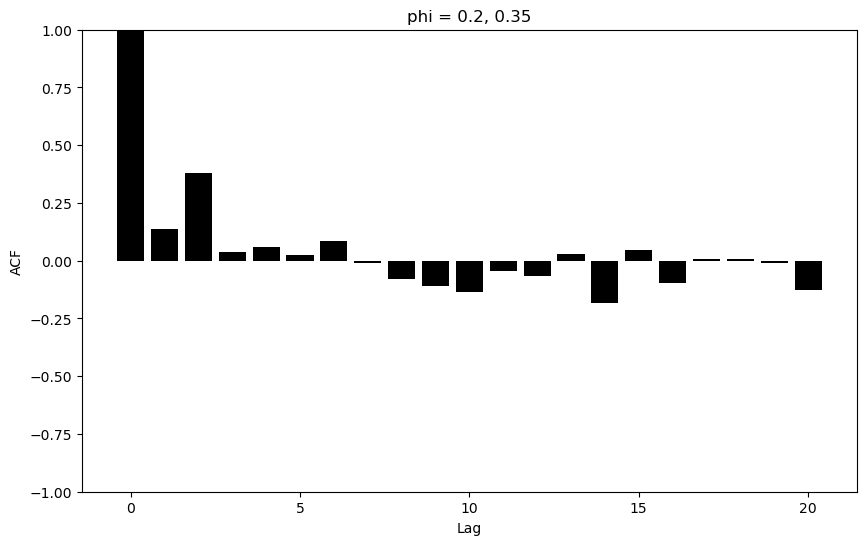

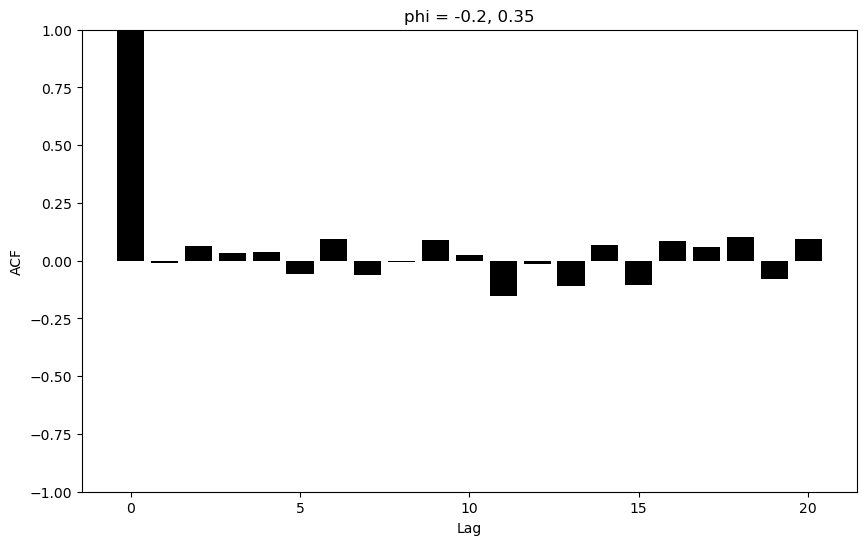

In [36]:
ex_AR2_2 = pd.Series(AR2(phi1=1.2, phi2=-0.35))
ex_AR2_3 = pd.Series(AR2(phi1=0.6, phi2=-0.4))
ex_AR2_4 = pd.Series(AR2(phi1=0.2, phi2=0.35))
ex_AR2_5 = pd.Series(AR2(phi1=-0.2, phi2=0.35))

show_ACF(ex_AR2_2, "phi = 1.2, -0.35")
show_ACF(ex_AR2_3, "phi = 0.6, -0.4")
show_ACF(ex_AR2_4, "phi = 0.2, 0.35")
show_ACF(ex_AR2_5, "phi = -0.2, 0.35")

### 부분 자기상관 함수(Partial ACF; PACF)
- 부분 자기상관 함수(PACF)
    - 부분 자기상관 함수(PACF), $p_l:=\hat{\phi_{ll}}$, $r_t$의 $r_{t-1}$,..., $r_{t-l}$에 대한 선형회귀의 $r_{t-l}$의 계수이다.
    - 다음 AR 모델을 순차적으로 보자
    $$r_t=\phi_{0,1}+\phi_{1,1}r_{t-1}+e_{1t}$$
    $$r_t=\phi_{0,2}+\phi_{1,2}r_{t-1}+\phi_{2,2}r_{t-2}+e_{2t}$$
    $$r_t=\phi_{0,3}+\phi_{1,3}r_{t-1}+\phi_{2,3}r_{t-2}+\phi_{3,3}r_{t-3}+e_{3t}$$
    $$...$$
    - $p_l$의 추정치는 $\hat{\phi_{ll}}$이고, $r_t$의 lag-$l$ 샘플 PACF라고 한다.
    - ACF는 $r_t$와 $r_{t-l}$ 사이의 "단순" 상관관계를 측정한다.
    - 반면에 PACF는 $r_{t-1}$, ..., $r_{t-l+1}$의 영향을 제어한 후 $r_t$와 $r_{t-l}$ 사이의 관련성을 측정한다.
    - 정상 가우시간 AR(p) 모델에서 샘플 PACF는 lag-$p$에서 끝난다.
        - $\hat{\phi}_{pp}$는 샘플 크기 $T$가 무한으로 발산함에 따라 $\phi_p$에 수렴한다.
        - $\hat{\phi}_{ll}$는 $l>p$일 때 0으로 수렴하고, 점근적 분산은 $1/T$이다.

### 예시
$r_t=\phi r_{t-1}+\epsilon_t$, $\phi=0.4$, $0.95$

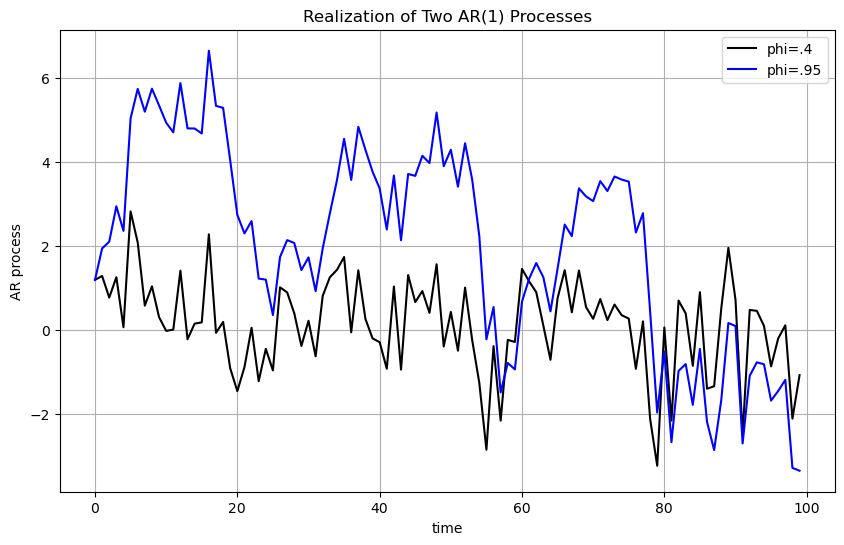

In [48]:
noise = np.random.normal(0, 1, 100)
data = [noise[0]]
for i in range(1, 100):
    data.append(0.4 * data[i-1] + noise[i])
ex_AR3_1 = pd.Series(data)

data = [noise[0]]
for i in range(1, 100):
    data.append(0.95 * data[i-1] + noise[i])
ex_AR3_2 = pd.Series(data)

plt.figure(figsize=(10, 6))
plt.plot(ex_AR3_1,  color='black', label='phi=.4')
plt.plot(ex_AR3_2,  color='b', label='phi=.95')
plt.xlabel("time")
plt.ylabel("AR process")
plt.title("Realization of Two AR(1) Processes")
plt.grid(True)
plt.legend()
plt.show()

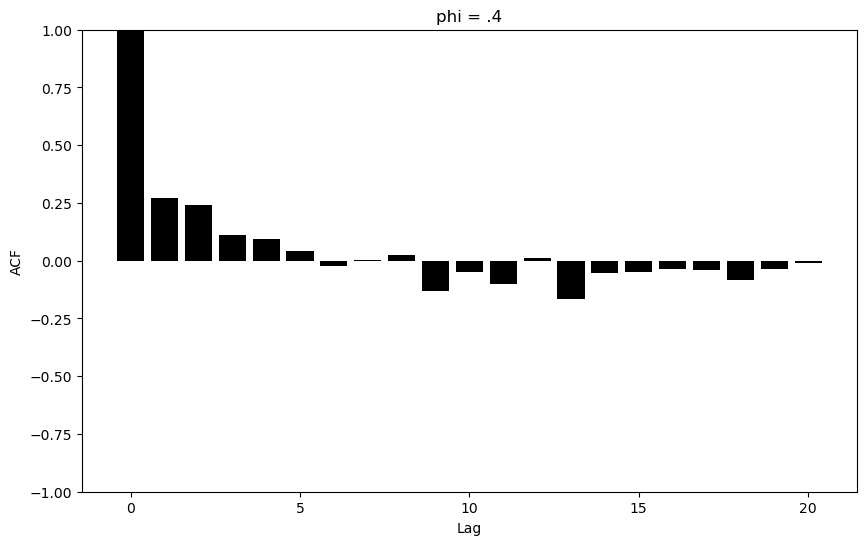

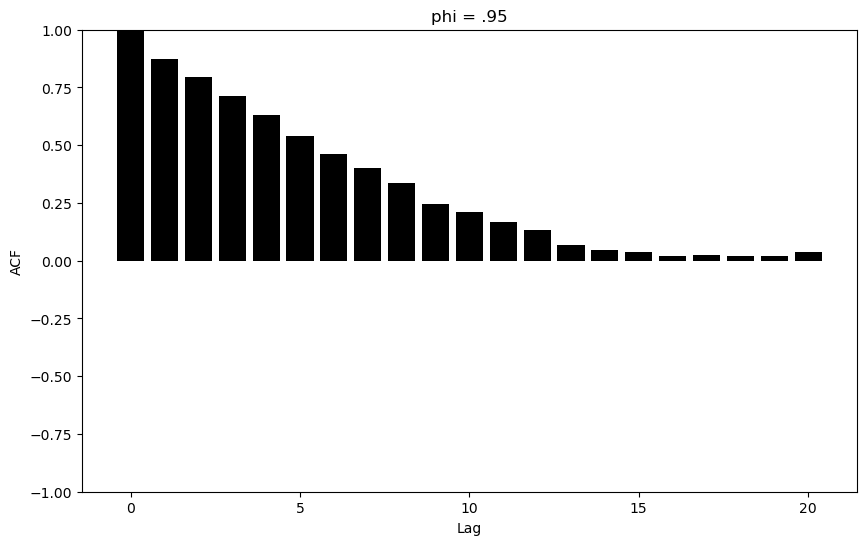

In [49]:
show_ACF(ex_AR3_1, "phi = .4")
show_ACF(ex_AR3_2, "phi = .95")

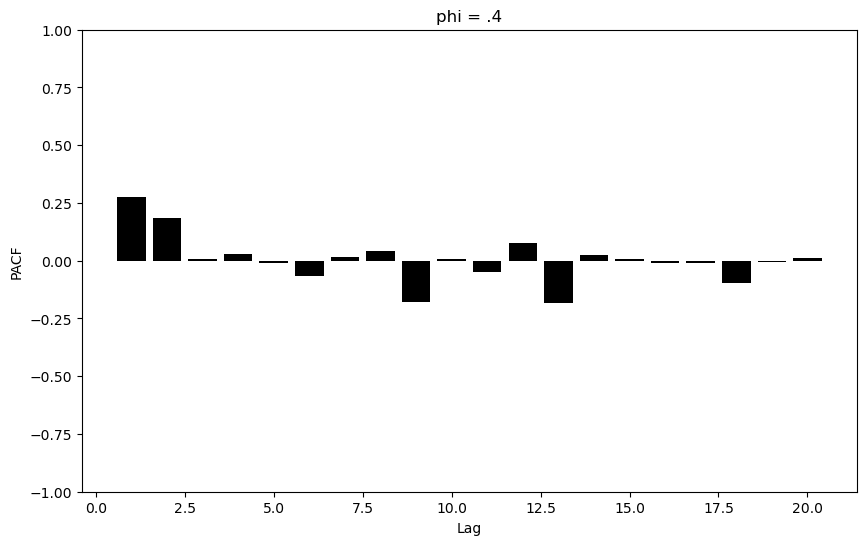

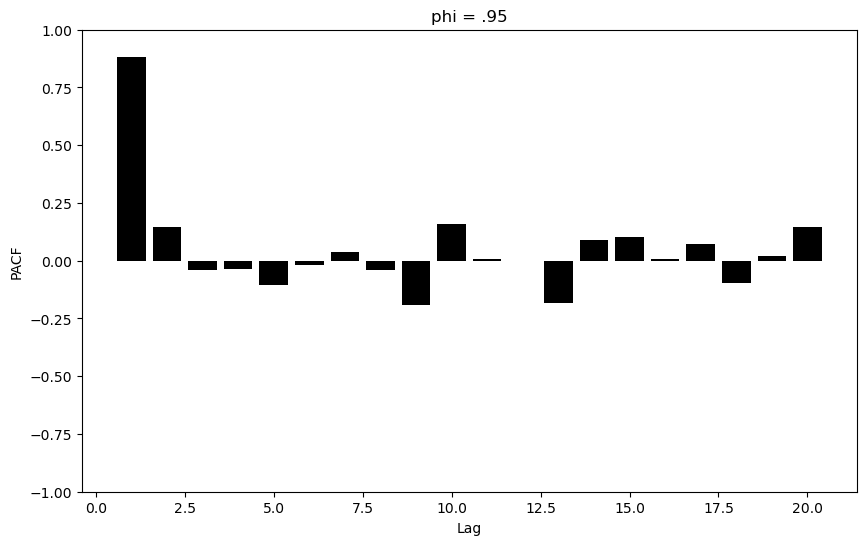

In [55]:
def show_PACF(series, title, start=1):
    plt.figure(figsize=(10, 6))
    PACF = pacf(series)
    plt.bar(range(start, PACF.shape[0]), PACF[start:], color='black')
    plt.xlabel("Lag")
    plt.ylabel("PACF")
    plt.ylim(-1, 1)
    plt.title(title)
    plt.show()
    
show_PACF(ex_AR3_1, "phi = .4")
show_PACF(ex_AR3_2, "phi = .95")

# 4. 이동 평균 (Moving Average; MA) 모델

### 이동 평균 (MA) 모델
- MA(1) 과정
$$r_t=\epsilon_t+\theta\epsilon_{t-1}=(1+\theta L)\epsilon_t,\quad\epsilon_t\sim WN(0,\sigma^2)$$
    - 가역이라면: $r_t=\epsilon_t+\theta r_{t-1}-\theta^2 r_{t-2}+\theta^3 r_{t-3}-...$.
    - 과거 값이 현재의 shock에 거의 영향을 미치지 않아야 하며, 이는 $|\theta|<1$일 때에 유지된다.
    - $\mathbb{E}[r_t] = 0$, $\mathrm{var}[r_t]=\sigma^2(1+\theta^2)$, $\mathbb{E}[r_t | \Omega_{t-1}] = \theta \epsilon_{t-1}$, $\mathbb{var}[r_t | \Omega_{t-1}] = \sigma^2$
    - $\gamma(\tau) = \theta \sigma^2 \cdot 1_{\tau=1}$, $\rho_0=0$, $\rho_1=\theta/(1+\theta^2)$, $\rho_l=0$, 이때 $l>1$

### 예시
1. $r_t=20+\epsilon_t+0.8\epsilon_{t-1}$, $\epsilon_t\sim WN(0,1)$
2. $r_t=\epsilon_t-\epsilon_{t-1}+0.8\epsilon_{t-2}$

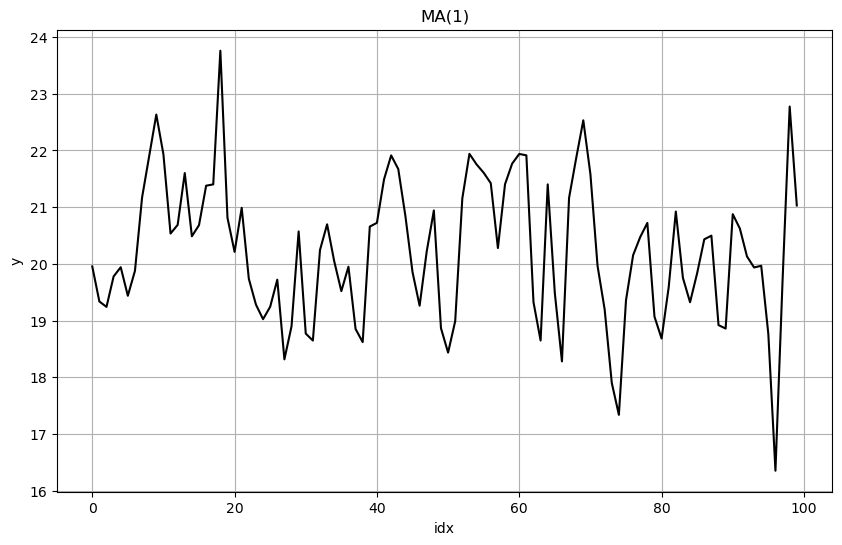

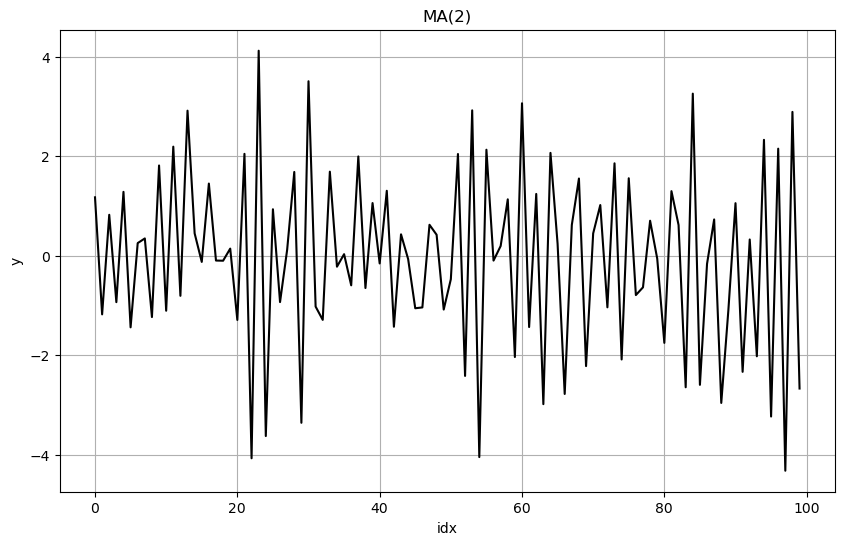

In [40]:
def MA1(c=0, theta=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c + noise[0]]
    for i in range(1, n):
        data.append(c + noise[i] + theta * noise[i-1])
    return data

def MA2(c=0, theta1=0, theta2=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c + noise[0], c + theta1 * noise[0] + noise[1]]
    for i in range(2, n):
        data.append(c + noise[i] + theta1 * noise[i-1] + theta2 * noise[i-2])
    return data

ex_MA1_1 = pd.Series(MA1(c=20, theta=0.8))
plot_series(ex_MA1_1, "idx", "y", "MA(1)")

ex_MA1_2 = pd.Series(MA2(theta1=-1, theta2=0.8))
plot_series(ex_MA1_2, "idx", "y", "MA(2)")

### $\theta$에 따른 ACF와 PACF
$r_t=\epsilon_t+\theta\epsilon_{t-1}$, $\theta=0.4$, $0.95$

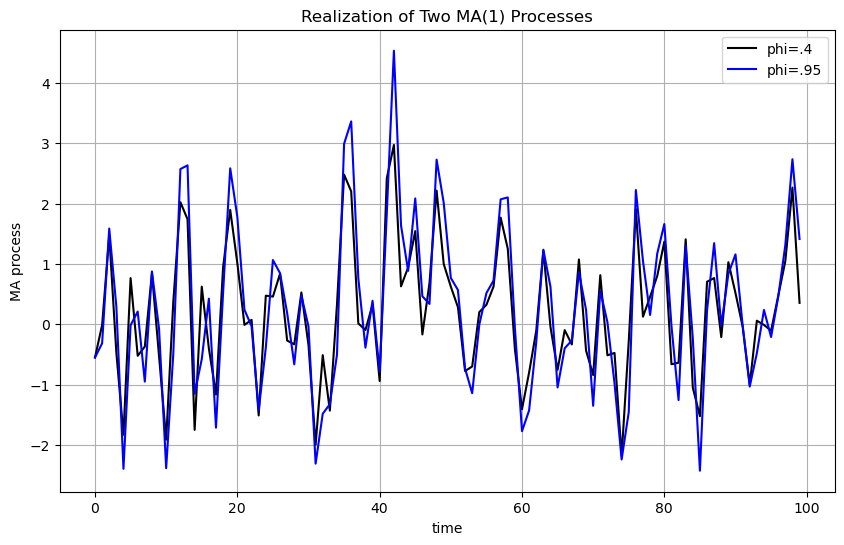

In [45]:
noise = np.random.normal(0, 1, 100)

data = [noise[0]]
for i in range(1, 100):
    data.append(noise[i] + 0.4 * noise[i-1])
ex_MA2_1 = pd.Series(data)

data = [noise[0]]
for i in range(1, 100):
    data.append(noise[i] + 0.95 * noise[i-1])
ex_MA2_2 = pd.Series(data)

plt.figure(figsize=(10, 6))
plt.plot(ex_MA2_1,  color='black', label='phi=.4')
plt.plot(ex_MA2_2,  color='b', label='phi=.95')
plt.xlabel("time")
plt.ylabel("MA process")
plt.title("Realization of Two MA(1) Processes")
plt.grid(True)
plt.legend()
plt.show()

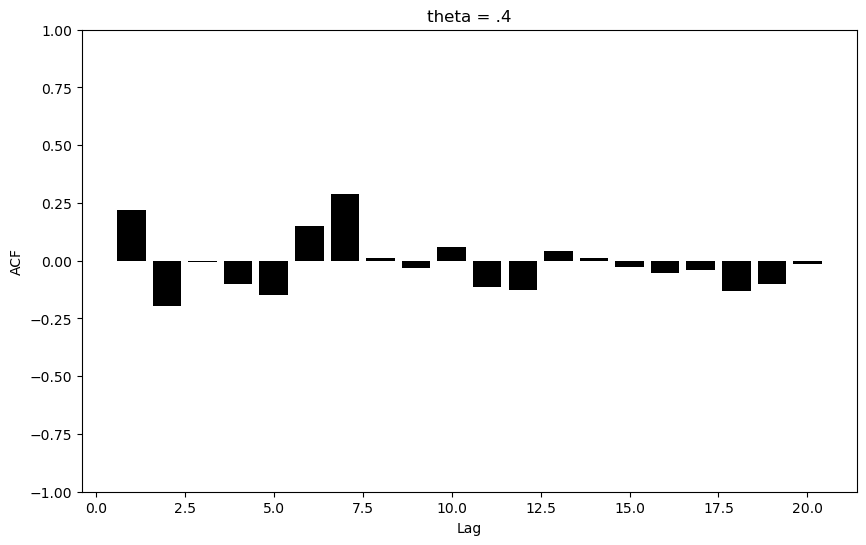

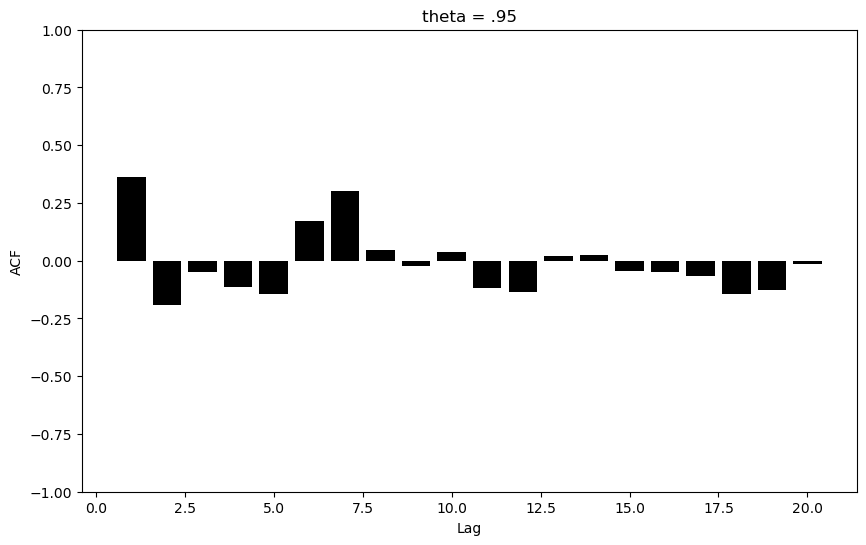

In [56]:
show_ACF(ex_MA2_1, "theta = .4", start=1)
show_ACF(ex_MA2_2, "theta = .95", start=1)

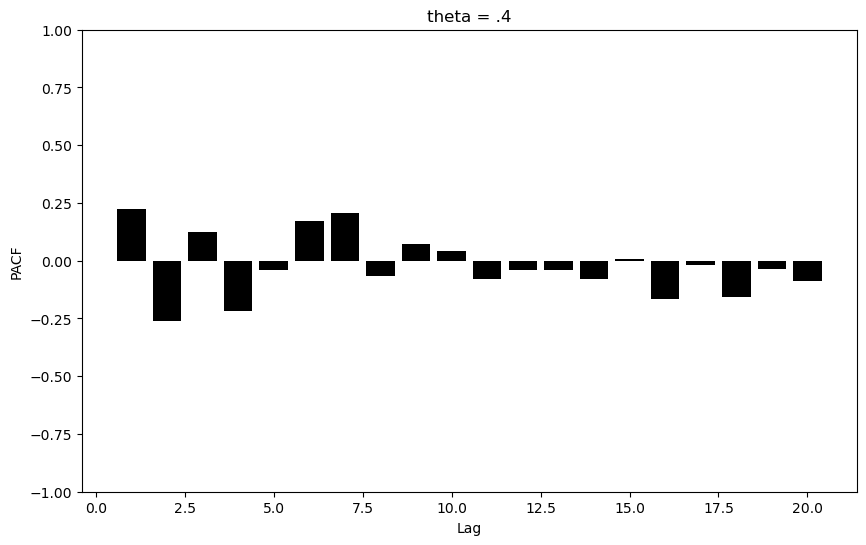

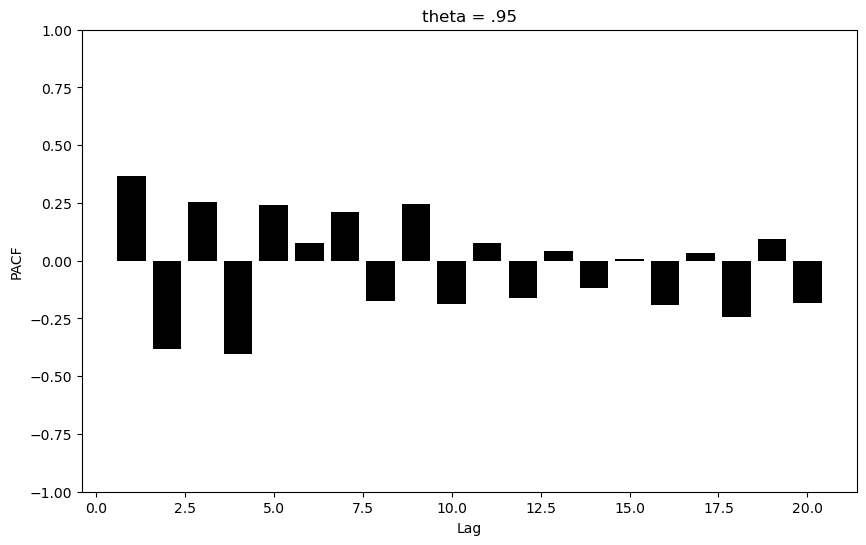

In [53]:
show_PACF(ex_MA2_1, "theta = .4")
show_PACF(ex_MA2_2, "theta = .95")

### MA(q) 모델
- MA(q) 모델
    - $r_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} = c_0 + (1 + \theta_1 L + \cdots + \theta_q L^q) \epsilon_t,\quad\epsilon_t\sim WN(0,\sigma^2)$
        - 과거 오차를 예측 변수로 사용한 다중 회귀이다.
        - 이동 평균 평활화와 혼동하지 마라.
    - 어떤 MA(q) 과정도 MA 변수에 일부 제약을 가하면 AR($\infty$) 과정으로 표현할 수 있다. 그 MA 모델을 "가역"이라고 부른다.
    - 가역성 일반적인 조건: 모든 특성근(특성 방정식 $1+\theta_1z+...+\theta_qz^q=0$의 해의 역수)의 절대값이 1보다 작다.
        - $q=1$일 때: $-1<\theta_1<1$
        - $q=2$일 때: $-1<\theta_2<1$, $\theta_2+\theta_1>-1$, $\theta_1-\theta_2<1$
    - MA(q) 모델은 항상 약정상 시계열이고, $\mathbb{E}[r_t]=\mu$, $\mathrm{var}[r_t]=(1+\theta_1^2+...+\theta_q^2)\sigma^2$이다.
    - $l\leq q$에 대해 $\gamma_l = \sigma2 \sum_{j=0}^{q-l} \theta_j \theta_{j+l}$이고, $l>q$에 대해 $\gamma_l=\rho_l=0$이다.
    - MA(q) 모델은 첫 q개의 지연된 값들과만 선형적으로 관련되어 있으므로 유한한-기억(finite-memory)이라고 한다.

### ACF와 PACF 구현
- ACF와 PACF 구현
    - AR(1)
        - $\rho_l=\phi^l$이고 $\hat{\phi}_{11}=\phi$, $l>1$에 대해 $\hat{\phi}_{ll}=0$이다.
        - 정상성 조건: $-1<\phi<1$
        - ACF는 지수적으로 감소하고, 하나의 중요한 PACF를 갖는다.
    - AR(p)
        - ACF는 지수적으로 감소하거나 감쇠 삼각함수를 보인다.
        - PACF가 lag $p$에서 끊기므로 PACF는 차수를 특정하는 데에 유용하다.
    - MA(1)
        - $\rho_1=\theta/(1+\theta^2)$, $l>1$에 대해 $\rho_l=0$이고 $\hat{\phi}_{ll}=-(-\theta)^l/(1+\theta^2+...+\theta^{2l})$
        - 가역 조건: $-1<\theta<1$
        - PACF는 지수적으로 감소하고, 하나의 중요한 ACF를 갖는다.
    - MA(q)
        - ACF가 lag $q$에서 끊기므로 ACF는 차수를 특정하는 데에 유용하다.
        - PACF는 지수적으로 감소하거나 감쇠 삼각함수를 보인다.

# 5. ARIMA 모델

### ARMA(p, q) 모델
- 자기회귀 이동 평균 모델 (ARMA(p,q) 모델)
$$r_t = \phi_0 + \sum_{i=1}^{p} \phi_i r_{t-i} + \epsilon_t + \sum_{i=1}^{q} \theta_i \epsilon_{t-i},\quad\epsilon_t\sim WN(0,\sigma^2)$$
$$\phi(L) r_t = (1 - \phi_1 L - \cdots - \phi_p L^p) r_t = \phi_0 + (1 + \theta_1 L + \cdots + \theta_q L^q) \epsilon_t = \phi_0 + \theta(L) \epsilon_t$$
$$\phi(L) r_t = \phi_0 + \theta(L) \epsilon_t,\quad\frac{\theta(L)}{\phi(L)} = \sum_{i=0}^{\infty} \psi_i L^i = \psi(L),\quad\frac{\phi(L)}{\theta(L)} = \sum_{i=0}^{\infty} \pi_i L^i = \pi(L)$$
    - 예측 변수에는 $r_t$의 지연값과 오차의 지연값을 모두 포함한다.
    - ACF는 AR 모델과 유사하게 작동한다.
    - PACF는 어떠한 지연에도 끊기지 않는다.
    - ARMA(1,1): $r_t=\phi_0+\phi r_{t-1}+\epsilon_t+\theta\epsilon_{t-1}$, $\epsilon\sim WN(0,\sigma^2)$
        - 가역인 경우 MA 표현: $r_t=\frac{1+\theta L}{1-\phi L}\epsilon_t$
        - 약정상인 경우 AR 표현: $\frac{1-\phi L}{1+\theta L}r_t=\epsilon_t$
            - $|\phi|<1$은 AR(1) 모델과 동일한 정상 조건이다.
        - $\mathbb{E}(r_t) = \mu = \frac{\phi_0}{1 - \phi_1}$, $\mathrm{var}[r_t] = \frac{(1 + 2\phi\theta + \theta^2)\sigma^2}{1 - \phi^2}$, $\gamma_l=\phi\gamma_{l-1}$, $\rho_1=\phi+\theta\sigma^2/\gamma_0$, $l>1$에 대해 $\rho_l=\phi\rho_{l-1}$

- ARMA 표현:
$$\phi(L) r_t = \phi_0 + \theta(L) \epsilon_t,\quad\frac{\theta(L)}{\phi(L)} = \sum_{i=0}^{\infty} \psi_i L^i = \psi(L),\quad\frac{\phi(L)}{\theta(L)} = \sum_{i=0}^{\infty} \pi_i L^i = \pi(L)$$
    - AR 표현: $\pi(L)r_t=\frac{\phi_0}{1-\phi_1-...-\phi_p}+\epsilon_t$
        - MA 계수에 대한 가역성 조건: 모든 $\theta(L)$의 해는 절대값이 1보다 크다.(특성근의 절대값이 1보다 작다)
        - 이 표현은 과거값에 대한 현재값의 의존성을 보여준다.
    - MA 표현: $r_t=\frac{\phi_0}{1-\phi_1-...-\phi_p}+\psi(L)\epsilon_t$
        - 계수 $\psi_i$는 ARMA 모델의 충격 반응 함수(impulse response function)로 참조된다.
        - AR 계수에 대한 정상성 조건: 특성 방정식의 모든 해가 절대값이 1보다 크면 ARMA 모델은 약정상이다. 이 경우 $E(r_t)=\mu=\frac{\phi_0}{1-\phi_1-...-\phi_p}$이고, 계수 $\psi_i$는 $i$가 증가함에 따라 지수적으로 감소한다.
        - 이 표현은 과거 shock가 현재값에 미치는 영향을 보여준다.
        - 이는 예측 오차의 분산을 계산하는 데 유용하다.
        - 정상 시계열의 평균 회귀에 대한 간단한 증명을 제공한다.

### 자기회귀 누적 이동 평균 모델 (Autoregressive integrated moving-average; ARIMA)
- 다음을 만족할 때 시계열 $\{r_t\}$이 ARIMA(p,d,q) 과정이라고 한다.
$$c_t = y_t - y_{t-1}, \quad c_t = \phi_0 + \sum_{i=1}^{p} \phi_i c_{t-i} + \epsilon_t + \sum_{i=1}^{q} \theta_i \epsilon_{t-i}$$
$$\phi(L)(1-L)y_t = \phi_0 + \theta(L) \epsilon_t$$
    - 만약 $r_t$와 $\Delta r_t=r_t-r_{t-1}$가 모두 단위근 비정상 시계열이지만 $c_t=(1-L)\Delta r_t=r_t-2r_{t-1}+r_{t-2}$가 약정상이고 ARMA(p,q) 과정이라면 $r_t$는 ARIMA(p,2,q) 과정이다.
    - 비정상 시계열을 하분을 통해 정상 시계열로 변환한다.
    - 금융에서는 가격 시계열이 비정상이라고 여기지만, 수익률 시계열인 $r_t=\ln{P_t}-\ln{P_{t-1}}$은 정상이다. 이러한 경우 로그 가격 시계열은 단위근 비정상이며 ARIMA 과정을 통해 취급할 수 있다.
    - ARIMA 모델의 가역성은 ETS 모델의 예측 가능성과 동일하다.
    - Shock은 영구적인 영향을 미친다: 예측은 평균으로 회귀하지 않는다.
    - 시간이 지남에 따라 분산이 무한대로 증가한다: 구간 예측이 무한대로 확대된다.
    - ARIMA 모델은 종종 추세나 계절성과 같은 시각적 데이터 구조로 해석하기 어렵다. 그러나 다양한 시계열 패턴을 포착할 수 있다.

### ARIMA 모델 이해하기
- ARIMA 모델 이해하기
    - $\phi_0=0$일 때
        - $d=0$이면 장기 예측이 0으로 간다.
        - $d=1$이면 장기 예측이 0이 아닌 상수로 간다.
        - $d=2$이면 장기 예측이 직선을 따라간다.
    - $\phi_0\neq0$일 때
        - $d=0$이면 장기 예측이 데이터의 평균으로 간다.
        - $d=1$이면 장기 예측이 직선을 따라간다.
        - $d=2$이면 장기 예측이 2차식을 따라간다.
    - 예측 분산과 $d$
        - $d$의 값이 커질수록 구간 예측의 크기가 빠르게 증가한다.
        - $d=0$이면 장기 예측의 표준편차가 과거 데이터의 표준편차로 점근한다.
    - 주기적 행동
        - 주기 예측의 경우, $p\leq2$과 계수에 대한 일부 조건이 필요하다.
        - $p=2$인 경우, $\phi_1^2+4\phi_2<0$이어야 한다. 주기의 평균 길이는 $(2\pi)/[\arccos{(-\frac{\phi_1(1-\phi_2)}{4\phi_2})}]$이다.

### 예시: 이집트 수출
- 다음과 같은 ARIMA(2,0,1) 모델이 관측된다.
$$r_t=20.18+1.68r_{t-1}-0.80r_{t-2}+\epsilon_t-0.69\epsilon_{t-1},\quad\epsilon\sim WN(0,7.491)$$

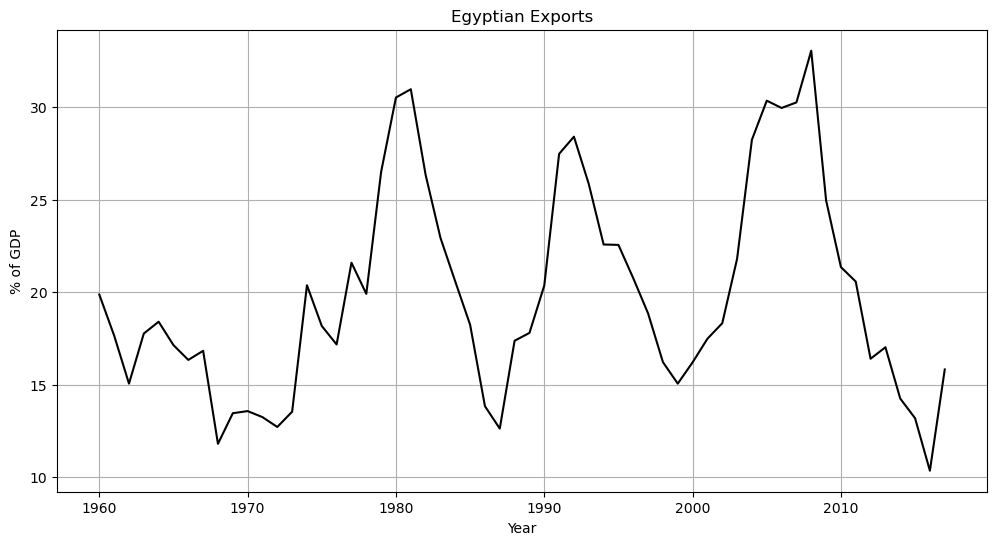

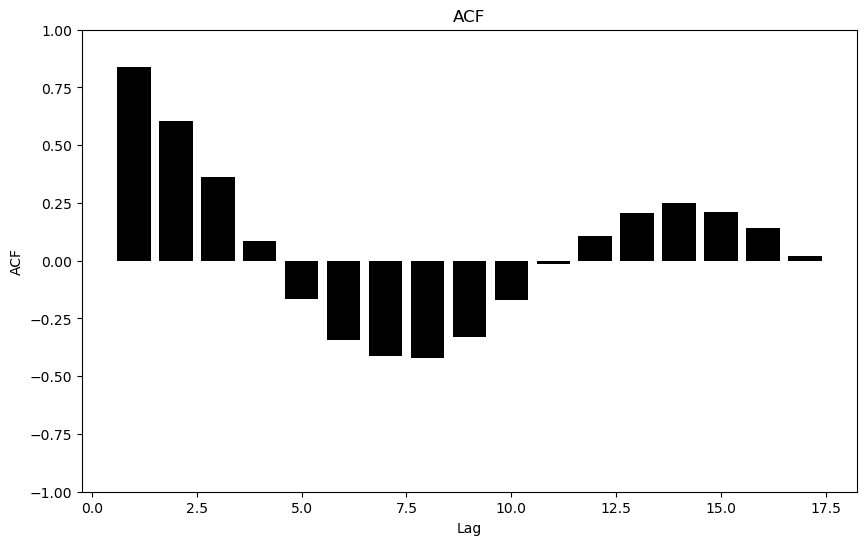

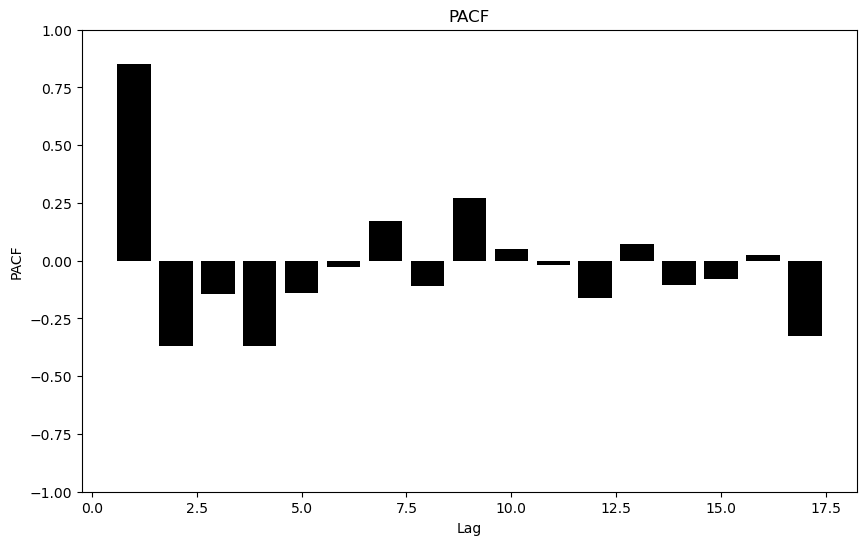

In [71]:
global_economy = pd.read_csv('global_economy.csv')
global_economy['Year'] = pd.to_datetime(global_economy['Year'], format='%Y')

egypt_exports = global_economy[global_economy['Code'] == 'EGY']
egypt_series = pd.Series(list(egypt_exports['Exports']), egypt_exports['Year'])
plt.figure(figsize=(12, 6))
plt.plot(egypt_series, color='black')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Egyptian Exports')
plt.grid(True)
plt.show()

show_ACF(egypt_series, "ACF", 1)
show_PACF(egypt_series, "PACF", 1)

In [75]:
egypt_mod = ARIMA(egypt_series, order=(2,0,1))
egypt_res = egypt_mod.fit()

print(egypt_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -141.566
Date:                Tue, 27 Feb 2024   AIC                            293.132
Time:                        18:39:15   BIC                            303.434
Sample:                    01-01-1960   HQIC                           297.145
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1790      0.972     20.766      0.000      18.274      22.084
ar.L1          1.6764      0.127     13.239      0.000       1.428       1.925
ar.L2         -0.8034      0.102     -7.905      0.0

C:\Users\YJPark\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\YJPark\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\YJPark\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


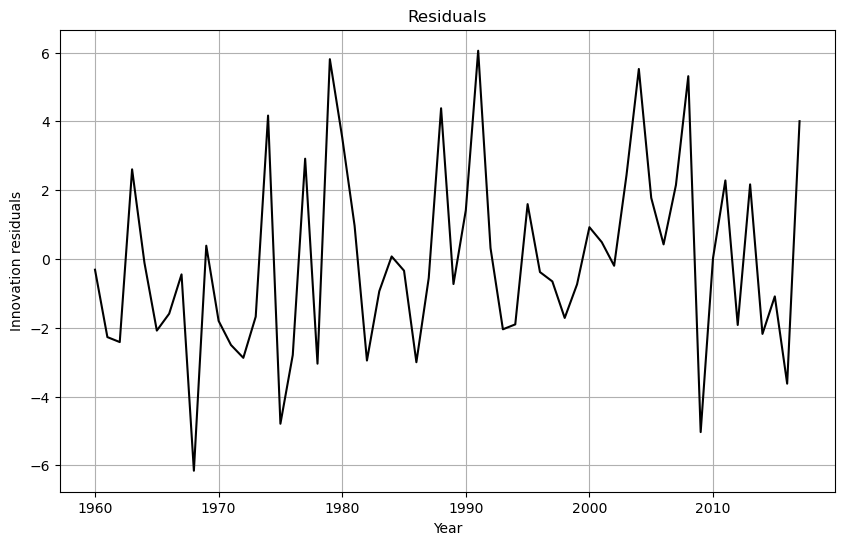

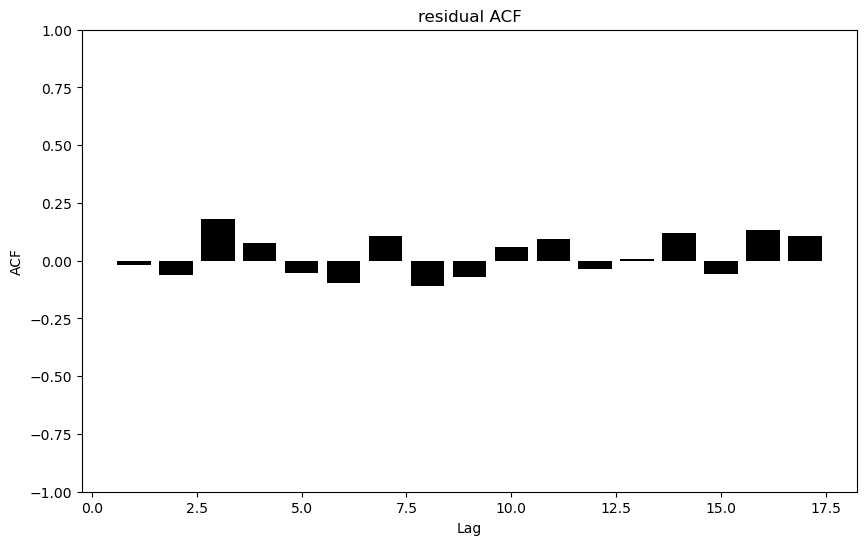

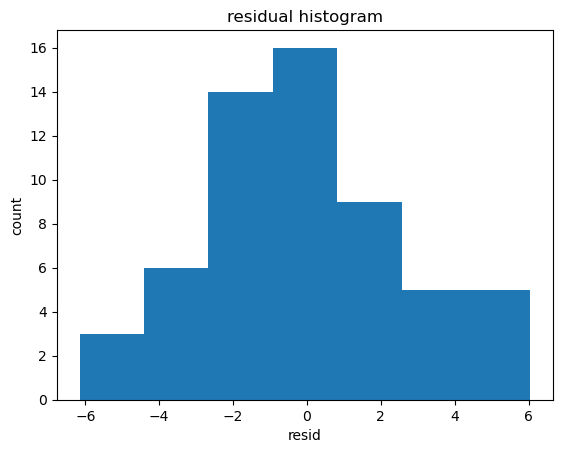

In [79]:
plot_series(egypt_res.resid, "Year", "Innovation residuals", "Residuals")
show_ACF(egypt_res.resid, "residual ACF", 1)

def hist_resid(res):
    plt.hist(egypt_res.resid, bins=7)
    plt.xlabel("resid")
    plt.ylabel("count")
    plt.title("residual histogram")
    plt.show()
    
hist_resid(egypt_res.resid)

# 6. 모델 선택

### 추정과 차수 선택
- 최대우도추정(Maximum-Likelihood)
    - 모델 차수가 식별된 후(즉, p, d, q 값이 결정된 후), 매개변수 $\phi_0,\phi_1,...,\phi_p,\theta_1,...,\theta_q$를 추정해야 한다.
    - 조건부 우도 방법은 초기 shock이 0이라고 가정한다.
    - 정확한 우도 방법은 초기 shock을 추가 매개변수로 처리하며 선호된다. 그러나 더 많은 연산이 요구된다.
- ARIMA 모델의 차수를 결정하는 데 유용한 척도(Imformation Criteria)
    - Akaike 척도(AIC): $AIC=-2\log{(L)}+2(p+q+k+1)$, $L$은 데이터의 우도이고 $\phi_0\neq0$인 경우 $k=1$, $\phi_0=0$인 경우 $k=0$이다.
    - 수정된 AIC(AICc): $AICc=AIC+2(p+q+k+1)(p+q+k+2)/(T-p-q-k-2)$이고 자주 선호된다.
    - 베이지안 척도(BIC): $BIC=AIC+[\log{(T)}-2](p+q+k+1)$
        * 이 척도들을 모델의 d가 아닌 p, q를 선택하는 데 사용한다. 차분은 데이터의 우도 계산에 변화를 가져온다. 다른 차수의 차분을 거친 데이터들의 우도는 비교하기 어렵다. 따라서 다른 방법으로 d를 결정한 후 AICc 등을 이용하여 p, q를 결정해야한다.

### ARIMA 모델링 과정
- R fable 패키지의 ARIMA() 함수(자동 선택을 위한 Hyndman-Khandakar 알고리즘)
    - 반복된 KPSS 검정을 통해 차분 차수($0\leq d\leq2$)를 결정한다.
    - p, q 값은 d차 차분된 데이터의 AICc를 최소화되는 값으로 결정된다. 모든 가능한 조합을 고려하지 않고 단계를 통한 알고리즘에 의해 탐색한다.
    1. 다음 4가지 초기 모델을 적합한다: ARIMA(0,d,0), ARIMA(2,d,2), ARIMA(1,d,0), ARIMA(0,d,1)
        - $d=2$가 아닌 경우 상수는 포함되어 있다. 만약 $d\leq1$이라면, 다음 추가 모델도 적합한다: 상수가 제외된 ARIMA(0,d,0)
    2. 위에서 가장 좋은 모델(가장 작은 AICc)이 현재 모델이 된다.
    3. 현재 모델에 대해 다음과 같은 변동을 준다:
        1. p 그리고/혹은 q에 $\pm1$을 한다.
        2. 현재 모델에 $\phi_0$을 포함/제외한다.
    4. 가장 좋은 모델이 현재 모델이 되어 반복한다.
    5. AICc가 감소하지 않을 때 종료한다.

![hyndmankhandakar](ARIMA_auto_selection.jpg)

<img src="ARIMA_algo1.jpg" width="200" height="200" title="1"></img><img src="ARIMA_algo2.jpg" width="200" height="200" title="2"></img><img src="ARIMA_algo3.jpg" width="200" height="200" title="3"></img><img src="ARIMA_algo4.jpg" width="200" height="200" title="4"></img>

### 예시: 중앙 아프리카 공화국 수출
- 감소 추세를 통해 1차 차분을 고려할 수 있다.
- ACF와 PACF를 통해 MA(3)과 AR(2)를 고려할 수 있다.

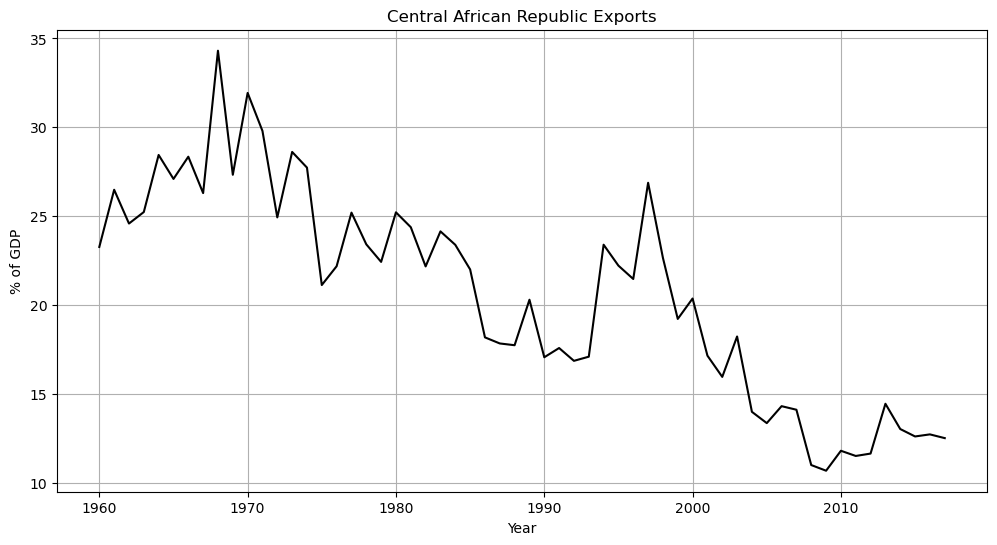

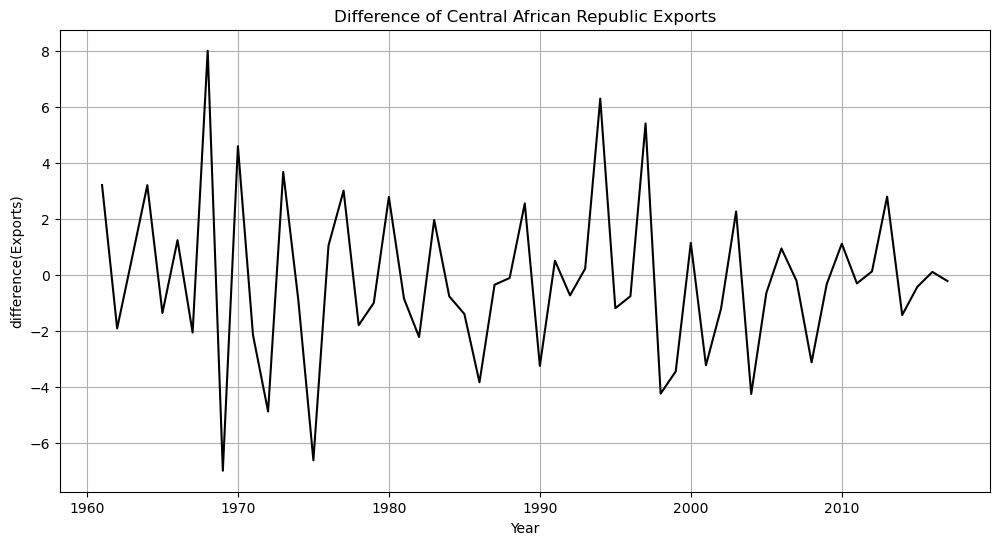

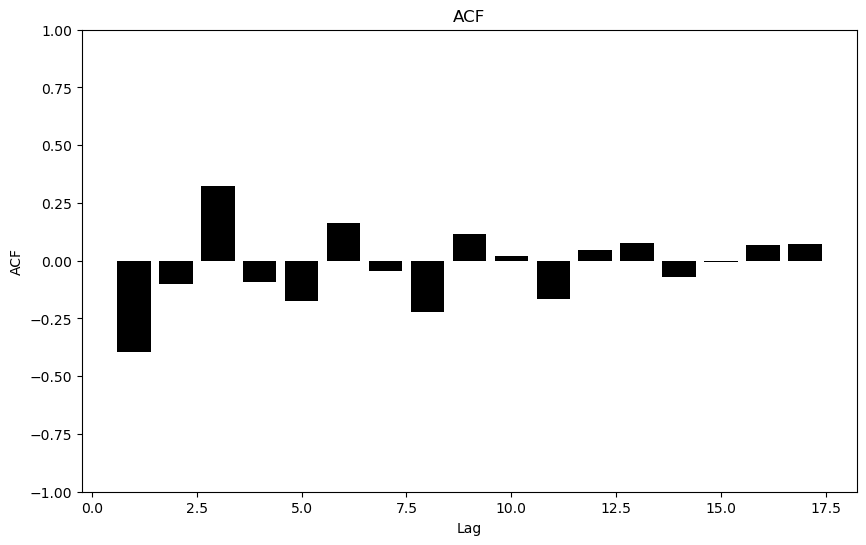

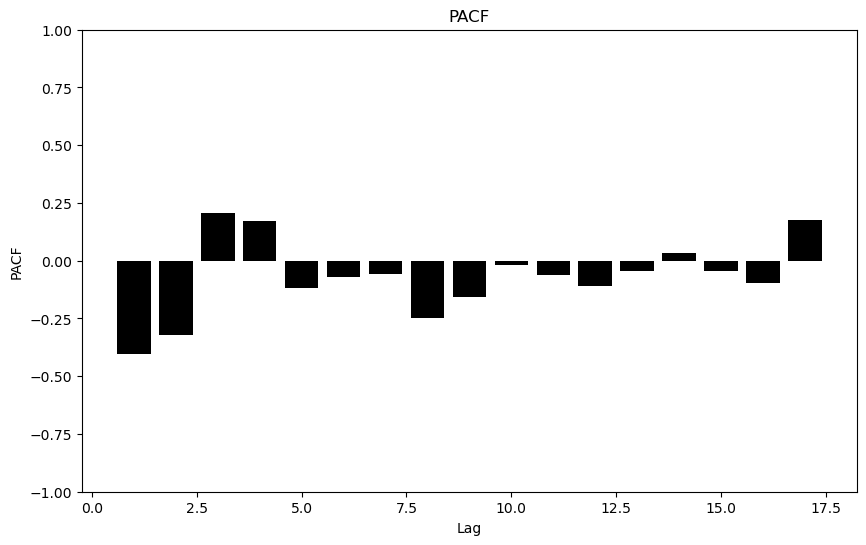

In [86]:
caf_exports = global_economy[global_economy['Code'] == 'CAF']
caf_series = pd.Series(list(caf_exports['Exports']), caf_exports['Year'])
plt.figure(figsize=(12, 6))
plt.plot(caf_series, color='black')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Central African Republic Exports')
plt.grid(True)
plt.show()

diff_caf_series = diff_series(caf_series)[1:]

plt.figure(figsize=(12, 6))
plt.plot(diff_caf_series, color='black')
plt.xlabel('Year')
plt.ylabel('difference(Exports)')
plt.title('Difference of Central African Republic Exports')
plt.grid(True)
plt.show()

show_ACF(diff_caf_series, "ACF", 1)
show_PACF(diff_caf_series, "PACF", 1)

In [90]:
caf_arima_mod = pm.auto_arima(caf_series, start_p=3, d=1, start_q=0, seasonal=False, information_criterion="aicc", m=1)
print(caf_arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -133.002
Date:                Tue, 27 Feb 2024   AIC                            274.005
Time:                        19:08:37   BIC                            282.177
Sample:                    01-01-1960   HQIC                           277.181
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4419      0.140     -3.152      0.002      -0.717      -0.167
ar.L2         -0.1850      0.176     -1.051      0.293      -0.530       0.160
ar.L3          0.2055      0.135      1.527      0.1

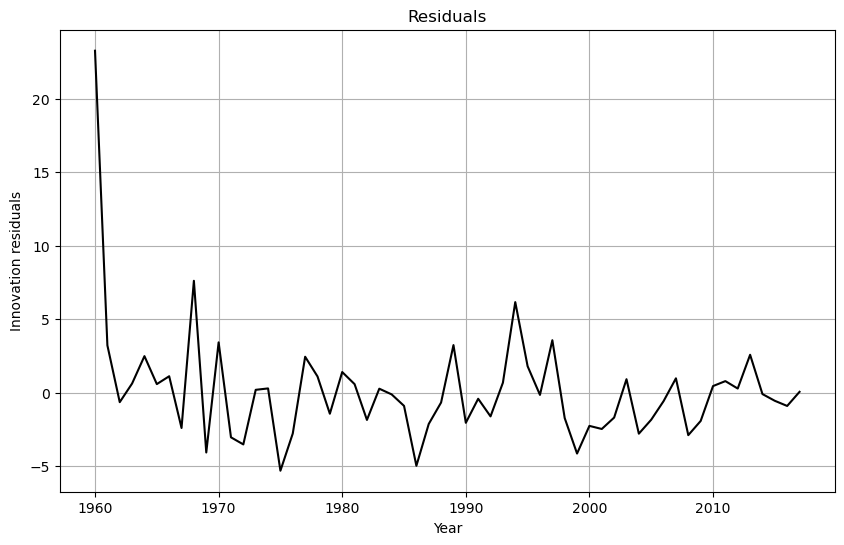

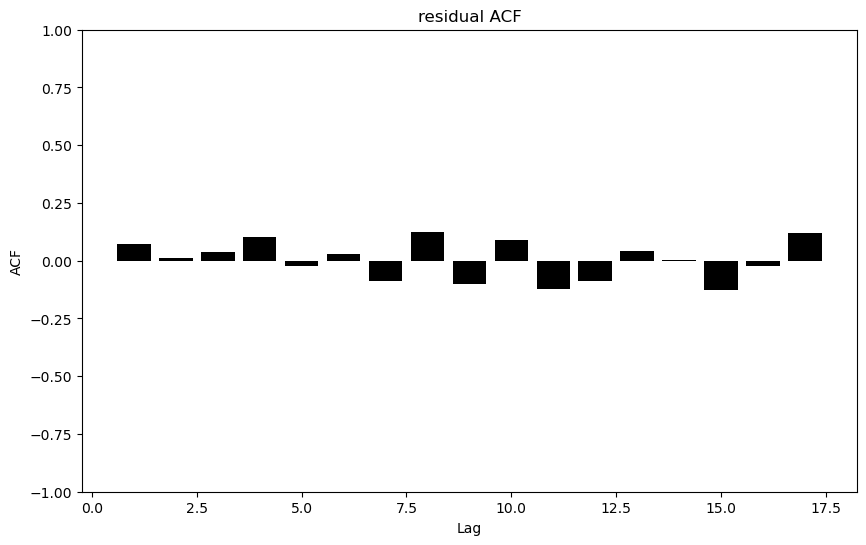

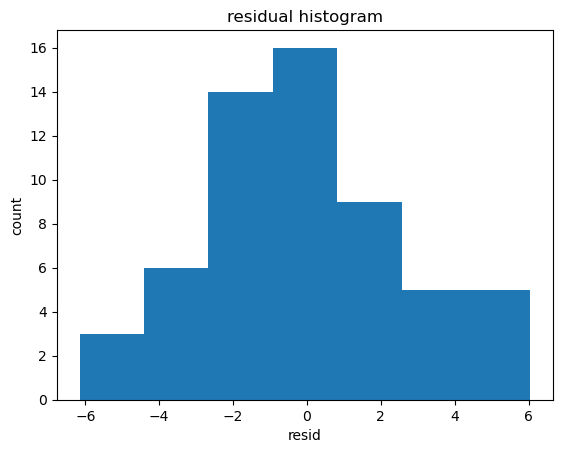

In [97]:
plot_series(caf_arima_mod.resid(), "Year", "Innovation residuals", "Residuals")
show_ACF(caf_arima_mod.resid(), "residual ACF", 1)
hist_resid(caf_arima_mod.resid())

### 예시: 캐나다 고용 지수
- AR(2) 모델과 MA(4) 모델을 비교할 수 있다.
- ARMA(3,1)이 가장 적합한 모델로 보인다.

# 7. 계절성 ARIMA 모델

### 계절성 ARIMA 모델
- 계절성 시계열
    - 시간에 따라 특정 주기적인 행동을 보이는 시계열은 계절성 시계열이라고 한다.
        - 시계열에서 계절성을 제거하는 절차를 계절 조정이라고 한다.
        - 일반적으로 주기 s를 갖는 계절성 시계열 $r_t$에 대해 $\Delta_sr_t=r_t-r_{t-s}=(1-L^s)r_t$를 사용한다.
        - $\Delta_s$를 계절성 차분이라고 한다.
- 시계열 $\{y_t\}$이 ARIMA$(p,d,q),(P,D,Q)_m$ 과정이다
$$(1 - \sum_{i=1}^{p} \phi_i L^i)(1 - \sum_{j=1}^{p} \Phi_j L^{j \times s})(1 - L)^d (1 - L^s)^D y_t = \phi_0 + (1 + \sum_{i=1}^{q} \theta_i L^i)(1 - \sum_{j=1}^{Q} \Theta_j L^{j \times s}) \epsilon_t$$
$$\phi(L)\Phi(L)(1-L)^d(1-L^s)^Dr_t=\phi_0+\theta(L)\Theta(L)\epsilon_t$$
    - $(p,d,q)=$비계절성 부분, $(P,D,Q)_m=$계절성 부분, $m=$연간 관측 수
    - Hyndman and Khandakar (JSS, 2008) 알고리즘:
        - KPSS 검정을 통해 차분 횟수 d 및 계절성 강도를 사용하여 D를 선택한다.
        - AICc를 최소화하는 p,q,P,Q,$\phi_0$를 선택한다.
        - 모델 공간을 탐색하기 위해 단계별 검색한다.
- 예시) ARIMA$(1,1,1)(1,1,1)_4$ 모델(상수 제외)
$$(1-\phi_1L)(1-\Phi_1L^4)(1-L)(1-L^4)r_t=(1-\theta_1L)(1-\Theta_1L^4)\epsilon_t$$
    - 왼쪽 항부터 순서대로 비계절성 AR(1),계절성 AR(1), 비계절성 차분, 계절성 차분, 비계절성 MA(1), 계절성 MA(1)이다.
- AR 또는 MA 모델의 계절 부분은 PACF와 ACF의 계절성 lag에서 볼 수 있다.
    - ARIMA$(0,0,0)(0,0,1)_{12}$는 다음을 보여준다:
        - ACF에서 12의 lag에서는 spike가 보이지만 다른 중요한 spike는 없다.
        - PACF의 계절성 lag에서 지수적으로 감소한다; 즉 12, 24, 36,...에서 감소한다.
    - ARIMA$(0,0,0)(1,0,0)_{12}$는 다음을 보여준다:
        - ACF의 계절성 lag에서 지수적으로 감소한다.
        - PACF에서 12의 lag에서 단일 중요 spike가 나타난다.

### 예시: 미국 레져 고용
- 비정상 시계열: 계절성과 증가 추세
- 계절성 차분과 일반 차분을 진행
- ACF의 2, 12 spike를 통해 q=MA(2), Q=MA(1) 추정
- PACF의 2 spike를 통해 p=AR(2) 추정
- ARIMA(0,1,2)(0,1,1)과 (2,1,0)(0,1,1) 확인

### 예시: 코르티코스테로이드 약물 판매량
- log로 데이터 크기 안정화
- 계절성 lag에서 ACF는 spike가 없음
- PACF의 12, 24 spike를 통해 P=AR(2) 추정
- PACF의 3 spike를 통해 p=AR(3) 추정
- ARIMA(3,0,0)(2,1,0) 확인
- 잔차가 화이트 노이즈라는 귀무가설이 기각
- 모든 test를 통과하기 쉽지 않음

# 8. 예측(Forecasting)

### 예측
- $h$-단계 다음 예측
    - 현재 시점 $T$(예측 기준 시점)에서 예측 범위(forecast horizon) $h>0$에 대해 $r_{T+h|T}$를 예측하고자 한다.
    - 최소 제곱 오차 손실 함수를 사용하여 $r_T$의 $h$-단계 다음 예측인 $\hat{r}_{T+h|T}$를 정한다.
    $$\mathbb{E}[(r_{T+h}-\hat{r}_{T+h|T})^2|F_T]=\mathrm{min}_g\mathbb{E}[(r_{T+h}-g)^2|F_T]$$
        - $g$는 $T$ 시점에 가능한 정보에 대한 함수이다.
        - $e_{T+h}=r_{T+h}-\hat{r}_{T+h|T}$는 $h$-단계 다음 예측 오차이다.
    - 합리적인 약한 조건(reasonably weak condition)하에서 최적의 예측은 조건부 평균이다. 즉, 사용 가능한 정보에 대한 조건부로 예측되는 시계열의 미래 값의 기대값이다: $$\hat{r}_{T+h|T}=\mathbb{E}[r_{T+h}|F_T]$$
    - 일반적으로 조건부 평균은 정보 집합의 요소들의 선형 함수가 아닐 수 있다. 선형 함수가 다루기 쉽기 때문에 선형 예측을 선호한다.
    - 선형 사영(linear projection)이라고 불리는 조건부 평균의 최적 선형 근사를 찾아 정보 집합 요소들에 대해 선형인 예측을 한다.

### AR(p) 모델 예측
- 1-단계 다음 예측
    - $\hat{r}_{T+1|T} = \mathbb{E}(r_{T+1} | F_T) = \phi_0 + \sum_{i=1}^{p} \phi_i r_{T+1-i}$ 그리고 $e_{T+1} = r_{T+1} - \hat{r}_{T+1|T} = \epsilon_{T+1}$
    - $\mathrm{Var}(e_{T+1})=\mathrm{Var}(\epsilon_{T+1})=\sigma^2$
- 2-단계 다음 예측
    - $\hat{r}_{T+2|T} = \mathbb{E}(r_{T+2} | F_T) = \phi_0 + \phi_1 \hat{r}_{T+1|T} + \sum_{i=2}^{p} \phi_i r_{T+1-i}$ 그리고 $e_{T+2} = r_{T+2} - \hat{r}_{T+2|T} = \phi_1 \epsilon_{T+1} + \epsilon_{T+2}$
    - $\mathrm{Var}(e_{T+2})=(1+\phi_1^2)\sigma^2\geq\mathrm{Var}(e_{T+1|T})$
    - 예측 범위가 증가함에 따라 예측의 불확실성도 증가한다.
- 다단계 다음 예측
    - $\hat{r}_{T+h|T}=\phi_0+\sum_{i=1}^{p} \phi_i \hat{r}_{T+h-i|T}$ 여기서 $i\leq0$일 때, $\hat{r}_{T+i|T}=r_{T+i}$이다.
    - $e_{T+h}=r_{T+h}-\hat{r}_{T+h|T}$
    - 정상 AR(p) 모델에 대해 $\hat{r}_{T+h|T}$는 $h\rightarrow\infty$에 따라 $\mathbb{E}(r_t)=\mu=\frac{\phi_0}{1-\phi_1-...-\phi_p}$로 수렴한다.
    - 이 속성을 평균 회귀(mean reversion)라고 한다.

### MA 모델 예측
- MA(1) 모델: $r_t=\mu+\epsilon_t+\theta_1\epsilon_{t-1}$
    - 1-단계 다음 예측
        - $\hat{r}_{T+1|T} = \mathbb{E}(r_{T+1} | F_T) = \mu + \theta_1 \epsilon_T$ 그리고 $e_{T+1} = r_{T+1} - \hat{r}_{T+1|T} = \epsilon_{T+1}$
        - $\mathrm{Var}(e_{T+1})=\mathrm{Var}(\epsilon_{T+1})=\sigma^2$
    - 2-단계 다음 예측
        - $\hat{r}_{T+1|T} = \mathbb{E}(r_{T+1} | F_T) = \mu + \theta_1 \epsilon_T$ 그리고 $e_{T+1} = r_{T+1} - \hat{r}_{T+1|T} = \epsilon_{T+1}$
        - $\mathrm{Var}(e_{T+2})=(1+\theta_1^2)\sigma^2\geq\mathrm{Var}(e_{T+1|T})$
        - $\hat{r}_{T+h|T}=\mu$, $h\geq2$
- MA(2) 모델: $r_t=\mu+\epsilon_t+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}$
    - $h$-단계 다음 예측
        - $\hat{r}_{T+1|T} = \mathbb{E}(r_{T+1} | F_T) = \mu + \theta_1 \epsilon_h + \theta_2 \epsilon_{h-1}$, $\hat{r}_{T+2|T} = \mathbb{E}(r_{T+2} | F_T) = \mu + \theta_2 \epsilon_{T-1}$, $\hat{r}_{T+h|T}=\mu$, $h>2$
- MA(q) 모델
    - 다단계 다음 예측은 첫 번째 $q$ 단계 이후에 평균으로 수렴한다.

### ARMA 모델 예측
- 예측
    - ARMA(p,q) 모델의 예측은 AR(p) 모델의 예측과 유사한 특성을 가진다.
    - 1-단계 다음 예측
        - $\hat{r}_{T+1|T} = \mathbb{E}(r_{T+1} | F_T) = \phi_0 + \sum_{i=1}^{p} \phi_i r_{T+1-i} + \sum_{i=1}^{q} \theta_i \epsilon_{T+1-i}$ 그리고 $e_{T+1} = r_{T+1} - \hat{r}_{T+1|T} = \epsilon_{T+1}$
        - $\mathrm{Var}(e_{T+1})=\mathrm{Var}(\epsilon_{T+1})=\sigma^2$
    - h-단계 다음 예측
        - $\hat{r}_{T+h|T} = \phi_0 + \sum_{i=1}^{p} \phi_i \hat{r}_{T+h-i|T} + \sum_{i=1}^{q} \theta_i \epsilon_{T+h-i}$ 여기서 $i\leq0$일 때 $\hat{r}_{T+i|T}=r_{T+i}$, $e_{T+i}=\epsilon_{T+i}$이고, $i>0$일 때 $e_{T+i}=0$이다.
        - $e_{T+h}=r_{T+h}-\hat{r}_{T+h|T}$
    - ARMA 모델의 다단계 다음 예측은 재귀적으로 연산될 수 있다.
    - 정상 시계열에 대해 다단계 다음 예측은 시계열의 평균으로 수렴하고, 예측 오차의 분산은 예측 범위가 증가함에 따라 시계열의 분산으로 수렴한다.

### ARIMA 모델 예측
- 점 예측: 예) ARIMA(3,1,1) 예측
    - $h=1$에서 시작. $h=2,3,...$으로 반복
    - $r_t$가 좌변에 오도록 ARIMA 방정식을 재배열
        - $(1-\hat{\phi}_1B-\hat{\phi}_2B^2-\hat{\phi}_3B^3)=(1+\hat{\theta}_1B)\epsilon_t$ ($h=1$)
    - 우변에 대해 미래 관측치가 해당 예측 값으로, 미래 오차를 0으로, 과거 오차를 잔차로 대체한다.
        - $\hat{r}_{T+1|T}=(1+\hat{\phi}_1)r_T-(\hat{\phi}_1-\hat{\phi}_2)r_{T-1}-(\hat{\phi}_2-\hat{\phi}_3)r_{T-2}-\hat{\phi}_3r_{T-3}+\hat{\theta}_1e_T$
        - $\hat{r}_{T+2|T}=(1+\hat{\phi}_1)r_{T+1|T}-(\hat{\phi}_1-\hat{\phi}_2)r_{T}-(\hat{\phi}_2-\hat{\phi}_3)r_{T-1}-\hat{\phi}_3r_{T-2}$
        - ...

### 예측 구간(Prediction intervals)
- 예측 구간: $\epsilon_t\sim WN(0,\sigma^2)$
    - 95% 예측 구간: $\hat{r}_{T+1|T}\pm1.96\sqrt{\hat{v}_{T+1|T}}$ 이때 $\hat{v}_{T+1|T}$는 추정 예측 분산이다.
    - 모든 ARIMA 모델에 대해 $\hat{v}_{T+1|T}=\hat{\sigma}^2$이다.
    - ARIMA(0,0,q)에 대한 다단계 예측 구간: $h=2,3,...$에 대해 $\hat{v}_{T+1|T}=\hat{\sigma}^2[1+\sum_{i=1}^{h-1}\hat{\theta}_i^2]$이다.
    - 예측 구간은 예측 범위의 크기에 따라 증가한다.
    - 예측 구간은 손으로 계산하기 어렵다.
    - 잔차가 상관 관계가 없고 정규 분포를 따른다는 가정하에서 계산된다.
    - 예측 구간이 너무 좁은 경향이 있다.
        - 모수 추정의 불확실상을 고려하지 않았다.
        - 모델의 불확실성을 고려하지 않았다.
        - ARIMA 모델은 예측 기간동안 과거의 패턴이 변하지 않을 것이라고 가정한다.
        - ARIMA 모델은 미래의 오차가 상관 관계가 없을 거이라고 가정한다.

### 예시: 예측

# 9. ARIMA v.s. ETS

### ARIMA v.s. ETS
- ARIMA v.s. ETS
    - ARIMA 모델이 ETS 모델보다 일반적이다는 잘못된 관념이다.
    - 선형 ETS 모델은 ARIMA 모델의 특수한 경우이다.
    - 비선형 ETS 모델은 대응되는 동등한 ARIMA 모델이 없다.
    - 상당 수의 ARIMA 모델은 대응되는 동등한 ETS 모델이 없다.
    - 계절성이나 비감쇠 추세 또는 둘 다 갖는 ETS 모델은 두 개의 단위근을 갖는다(즉, 정상성을 위해 2차 차분이 필요). 다른 모든 ETS 모델은 하나의 단위근을 갖는다(정상성을 위해 1차 차분이 필요).

$\begin{table}[]
\begin{tabular}{|lll|}
\hline
ETS 모델     & ARIMA 모델     & 매개변수 \\ \hline
ETS(A,N,N) & ARIMA(0,1,1) &      \\
ETS(A,A,N) & ARIMA(0,2,2) &      \\
           &              &      \\
           &              &      \\ \hline
\end{tabular}
\end{table}$

| ETS 모델   | ARIMA 모델   | 매개변수 |
|------------|--------------|----------|
| ETS(A,N,N) | ARIMA(0,1,1) | $\theta_1$=$\alpha$-1 |
| ETS(A,A,N) | ARIMA(0,2,2) | $\theta_1$=$\alpha$+$\beta$-2 |
|            |              | $\theta_2$=1-$\alpha$ |
| ETS(A,$A_d$,N) | ARIMA(1,1,2) | $\phi_1$=$\phi$ |
|            |              | $\theta_1$=1-$\alpha$+$\phi$$\beta$-1-$\phi$ |
|            |              | $\theta_2$=(1-$\alpha$)$\phi$ |
| ETS(A,N,A) | ARIMA(0,0,m)(0,1,0)$_m$ |          |
| ETS(A,A,A) | ARIMA(0,1,m+1)(0,1,0)$_m$ |          |
| ETS(A,$A_d$,A) | ARIMA(1,0,m+1)(0,1,0)$_m$ |          |

### 예시: 호주 인구

### 예시: 시멘트 생산